Link na report:
https://docs.google.com/document/d/18-76LLCtAzINi_Jn0EOvB-3iF7XuXKNxzpjyLAJTq5o/edit?usp=sharing


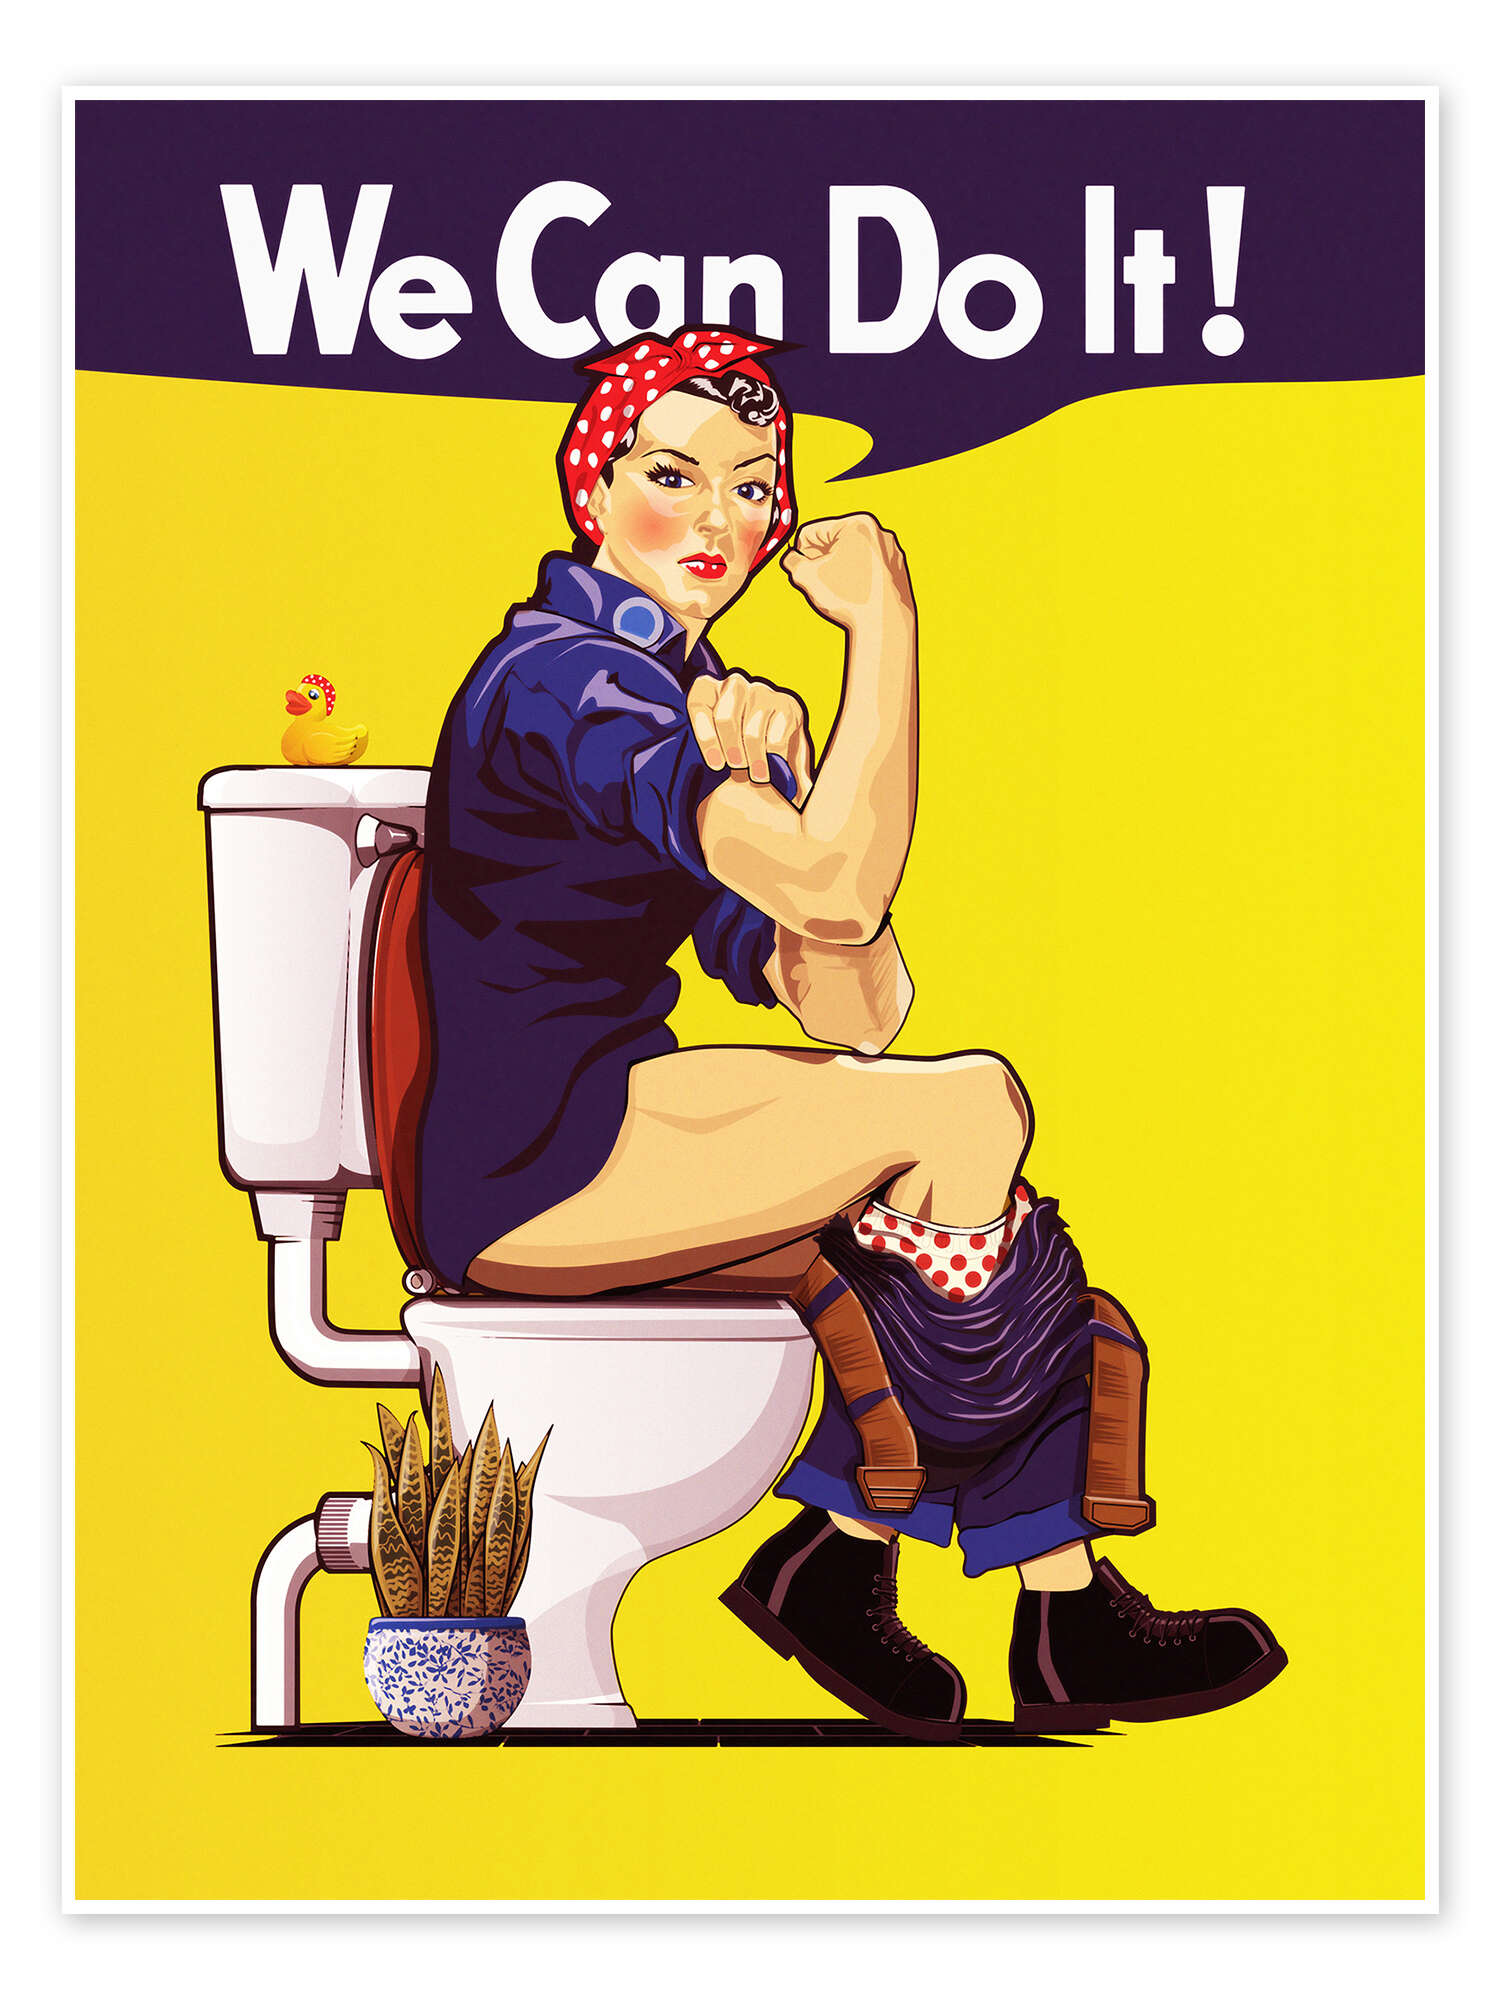

# **Import Knižníc**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import norm

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
!pip install wget

# **Načítanie dát**

In [ ]:
!wget https://raw.githubusercontent.com/dadopito/pridav_project/main/movies_2.tsv
!wget https://raw.githubusercontent.com/dadopito/pridav_project/main/dirs_writrs.tsv
!wget https://raw.githubusercontent.com/dadopito/pridav_project/main/merged_nonpop_movies.tsv
!wget https://raw.githubusercontent.com/dadopito/pridav_project/main/merged_pop_movies.tsv

--2024-01-08 20:29:12--  https://raw.githubusercontent.com/dadopito/pridav_project/main/movies_2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33943876 (32M) [text/plain]
Saving to: ‘movies_2.tsv.1’

movies_2.tsv.1      100%[===================>]  32.37M   162MB/s    in 0.2s    

2024-01-08 20:29:12 (162 MB/s) - ‘movies_2.tsv.1’ saved [33943876/33943876]

--2024-01-08 20:29:13--  https://raw.githubusercontent.com/dadopito/pridav_project/main/dirs_writrs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23978705 (23M) [text

In [ ]:
movies = pd.read_csv('movies_2.tsv', delimiter='\t', low_memory=False)
movies = movies.drop('Unnamed: 0', axis=1)

nonpop_movies = pd.read_csv('merged_nonpop_movies.tsv', keep_default_na=False, na_values=[''])
pop_movies = pd.read_csv('merged_pop_movies.tsv', keep_default_na=False, na_values=[''])

directors_writers = pd.read_csv('dirs_writrs.tsv', delimiter='\t')
directors_writers = directors_writers.drop('Unnamed: 0', axis=1)

print(movies.shape)
display(movies.head())
movies.replace('\\N', float('nan'), inplace=True)
movies = movies.sort_values(by='releaseYear')


(302207, 11)


tconst                   primaryTitle                  originalTitle  \
0  tt0000009                     Miss Jerry                     Miss Jerry   
1  tt0000147  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight   
2  tt0000502                       Bohemios                       Bohemios   
3  tt0000574    The Story of the Kelly Gang    The Story of the Kelly Gang   
4  tt0000591               The Prodigal Son              L'enfant prodigue   

   isAdult releaseYear runtimeMinutes                      genres  \
0        0        1894             45                     Romance   
1        0        1897            100      Documentary,News,Sport   
2        0        1905            100                          \N   
3        0        1906             70  Action,Adventure,Biography   
4        0        1907             90                       Drama   

   averageRating  numVotes  directors                        writers  
0          5.300       208  nm0085156                      nm0085156  
1          5.300       490  nm0714557                             \N  
2          4.100        15  nm0063413  nm0063413,nm0657268,nm0675388  
3          6.000       862  nm0846879                      nm0846879  
4          5.000        21  nm0141150                      nm0141150

# **Exploratívna analýza**

##**Základné info o dátach**

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
movies['releaseYear'] = pd.to_numeric(movies['releaseYear'], errors='coerce')
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')
display(movies.describe())

for column in ['genres', 'primaryTitle', 'originalTitle', 'tconst', 'directors', 'writers']:
    print(f"Short description of {column}:\n{movies[column].describe().to_string()}\n")

# najcastejsie hodnoty
for column in ['isAdult', 'releaseYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes']:
  most_common = movies[column].value_counts().idxmax()
  print(f'Most common value in column \'{column}\' is {most_common}.')
print()

# pocet chybajucich
for column in movies.columns:
    movies[column] = movies[column].replace(r'^\\N$', pd.NA, regex=True)
    count_NA = (movies[column].isna()).sum()
    print(f'In column \'{column}\' are {count_NA} missing values.')
print()

#pocet filmov ktorych povodny nazov a primarny sa nerovnaju
count_not_equal = len(movies[movies['primaryTitle'] != movies['originalTitle']])
print(f'Number of movies which primary and original title are not the same is {count_not_equal}.')

#vidime ze kazdy film je tam len 1x
print(f"Every movie is only {movies['tconst'].value_counts().max()} time in dataframe.")

print(f'Median of number of votes is {movies["numVotes"].median()}')

#odstranime z dat rovno tu NaN kde by robili problemy
movies.dropna(subset=['averageRating', 'genres', 'releaseYear'], inplace=True)

isAdult  releaseYear  runtimeMinutes  averageRating    numVotes
count 302207.000   302170.000      272333.000     302207.000  302207.000
mean       0.015     1995.230          94.456          6.177    3628.723
std        0.123       25.890         137.279          1.374   35858.957
min        0.000     1894.000           1.000          1.000       5.000
25%        0.000     1979.000          81.000          5.300      19.000
50%        0.000     2005.000          91.000          6.300      61.000
75%        0.000     2016.000         103.000          7.100     315.000
max        1.000     2024.000       51420.000         10.000 2837594.000

Short description of genres:
count     292117
unique      1275
top        Drama
freq       51177

Short description of primaryTitle:
count     302207
unique    268347
top       Mother
freq          33

Short description of originalTitle:
count     302207
unique    277378
top       Hamlet
freq          24

Short description of tconst:
count        302207
unique       302207
top       tt0000009
freq              1

Short description of directors:
count        298643
unique       127968
top       nm0627864
freq            196

Short description of writers:
count        264785
unique       202469
top       nm0960106
freq            214

Most common value in column 'isAdult' is 0.
Most common value in column 'releaseYear' is 2019.0.
Most common value in column 'runtimeMinutes' is 90.0.
Most common value in column 'genres' is Drama.
Most common value in column 'averageRating' is 6.2.
Most common value in column 'numVotes' is 9.

In column 'tconst' are 0 missing values.
In column 'primaryTitl

In [ ]:
movies.columns

Index(['tconst', 'primaryTitle', 'originalTitle', 'isAdult', 'releaseYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes', 'directors',
       'writers'],
      dtype='object')

## **Lineárna regresia**

### **Všetky filmy**

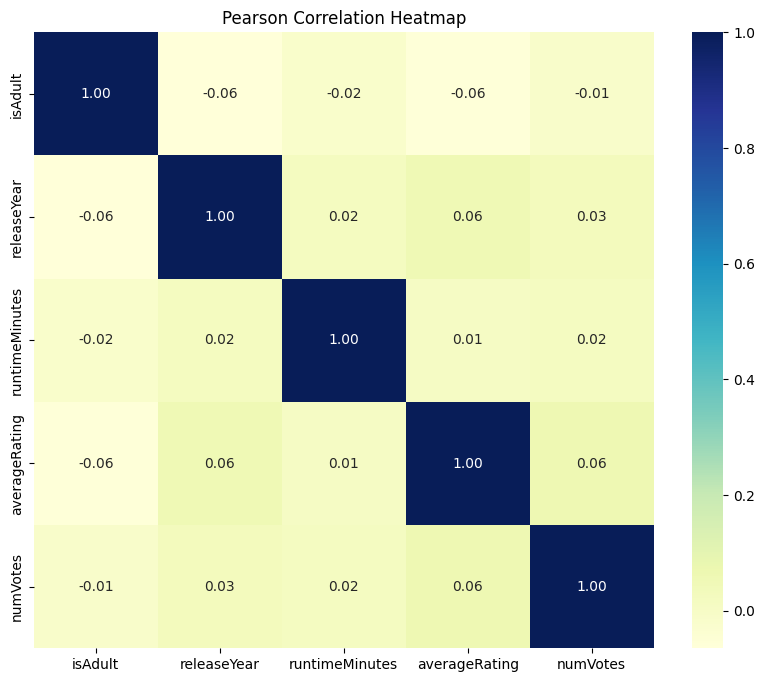

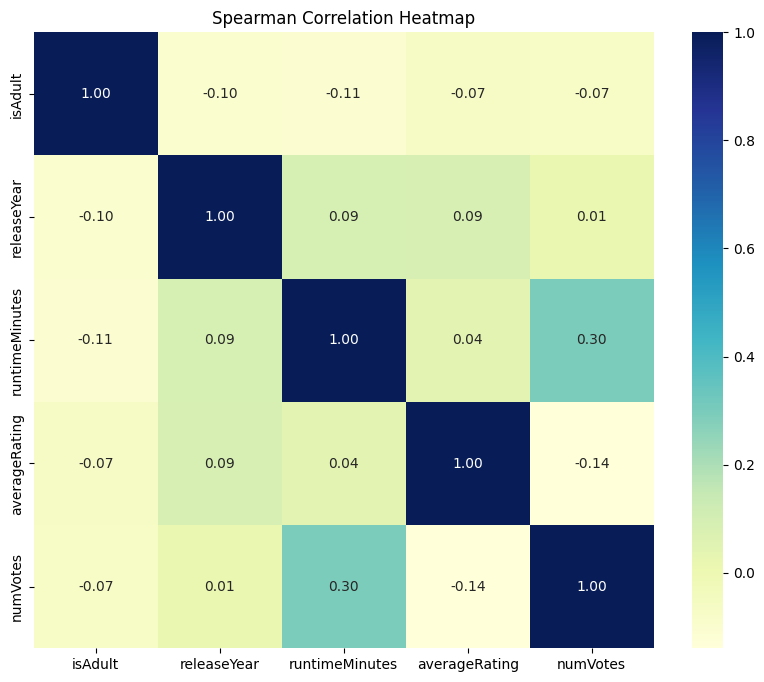

In [ ]:
numeric_columns = movies.select_dtypes(include='number')

pearson_correlation_matrix = numeric_columns.corr()
spearman_correlation_matrix = numeric_columns.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Pearson Correlation Heatmap')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Spearman Correlation Heatmap')
plt.show()

### **Filmy ktoré majú počet hlasov väčší ako priemer**

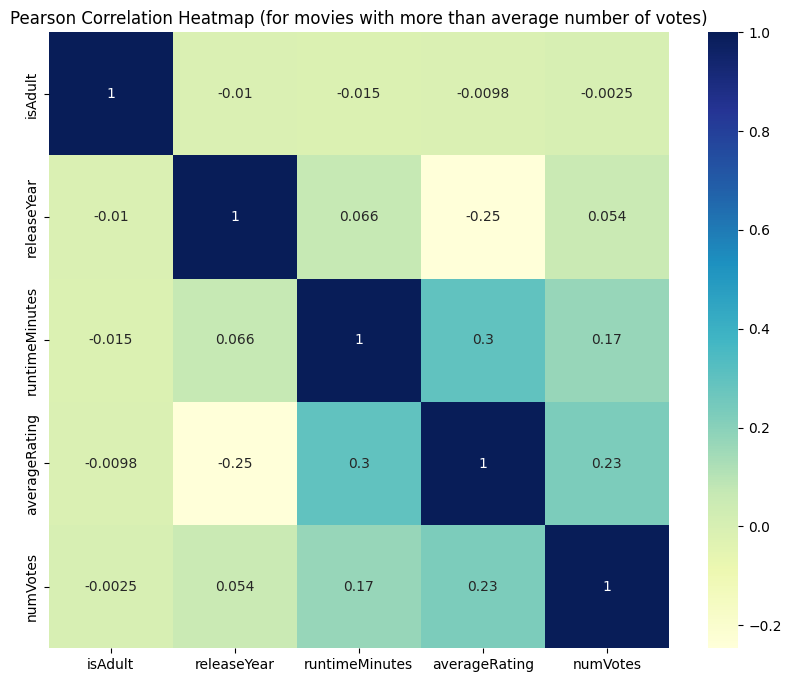

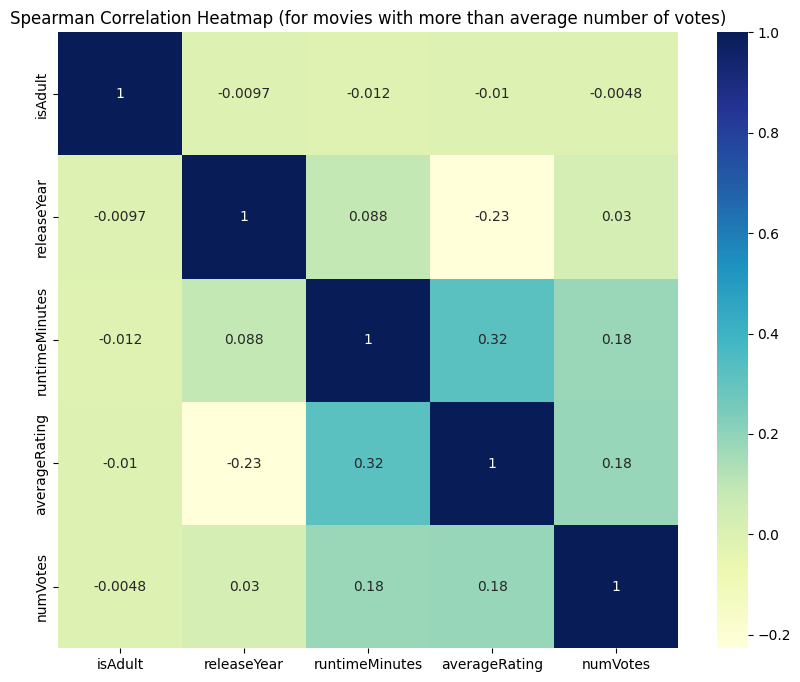

In [ ]:
movies_numVotesAboveAvg = movies[movies['numVotes']>movies['numVotes'].mean()]

numeric_columns = movies_numVotesAboveAvg.select_dtypes(include='number')

pearson_correlation_matrix = numeric_columns.corr()
spearman_correlation_matrix = numeric_columns.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Pearson Correlation Heatmap (for movies with more than average number of votes)')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Spearman Correlation Heatmap (for movies with more than average number of votes)')
plt.show()

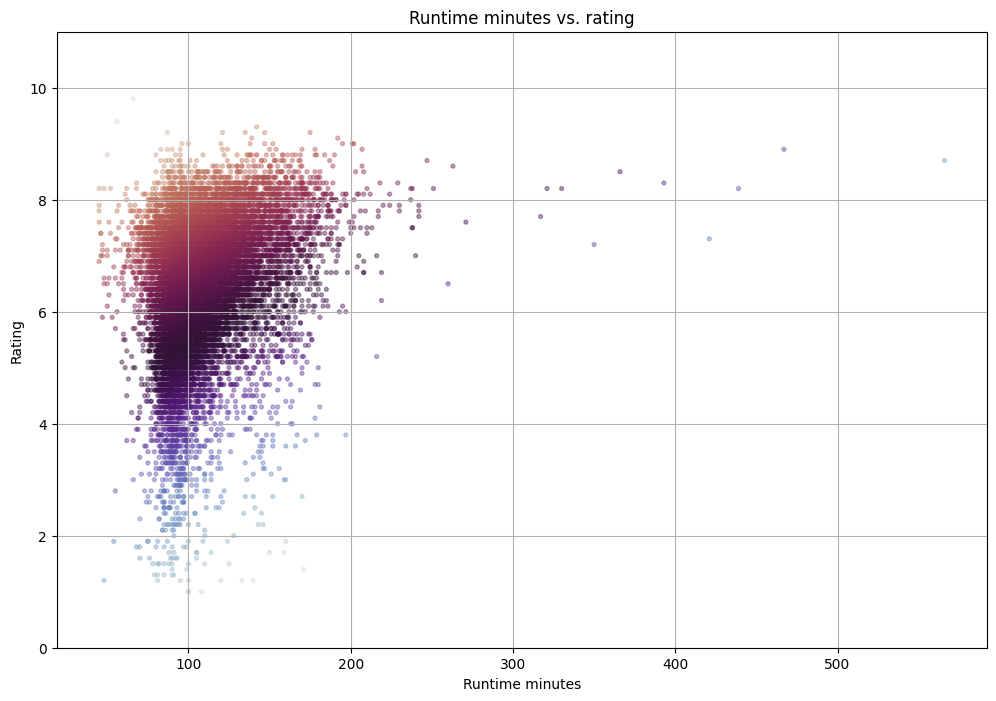

In [ ]:
movies_sufficientNumVotes = movies[(movies['numVotes'] > movies['numVotes'].mean()) & (movies['runtimeMinutes'] < 1000)]

x = movies_sufficientNumVotes['runtimeMinutes']
y = movies_sufficientNumVotes['averageRating']

#lin. regresia
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
residuals = y - polynomial(x)
normalized_residuals = (residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals))
color_values = normalized_residuals * 2 - 1

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=color_values, cmap='twilight', s=8, alpha=0.4)

plt.title('Runtime minutes vs. rating')
plt.xlabel('Runtime minutes')
plt.ylabel('Rating')
plt.grid(True)
plt.ylim(0, 11)
plt.show()

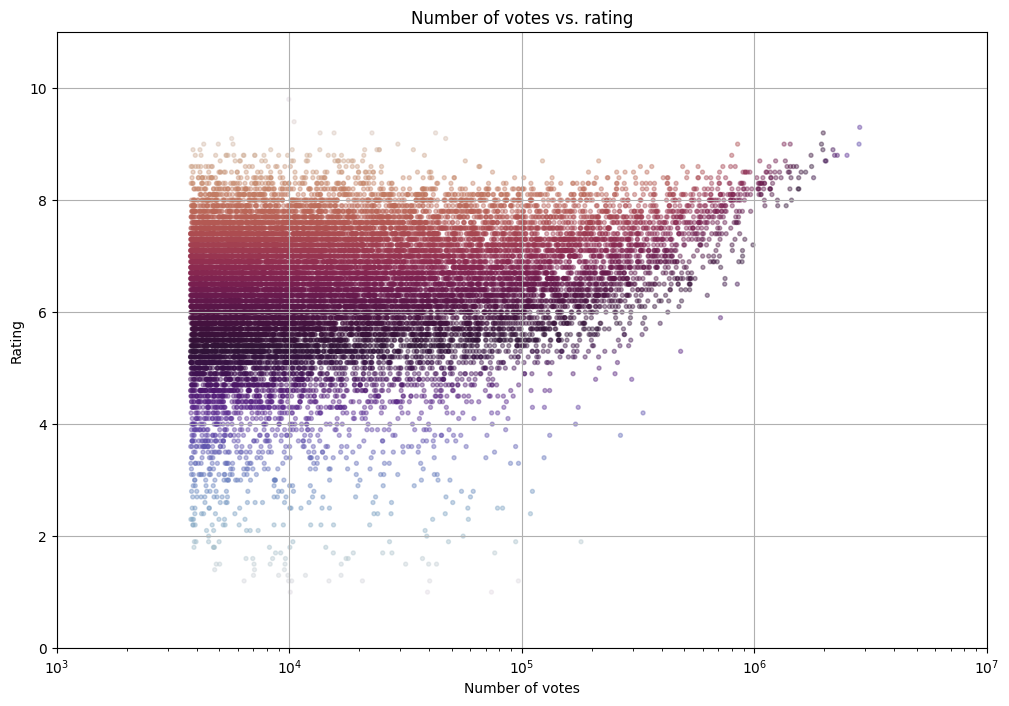

In [ ]:
movies_sufficientNumVotes = movies[movies['numVotes']>movies['numVotes'].mean()] #odfiltrovala som nizke hodnoty

x = movies_sufficientNumVotes['numVotes']
y = movies_sufficientNumVotes['averageRating']

#lin. regresia
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
residuals = y - polynomial(x)
normalized_residuals = (residuals - np.min(residuals)) / (np.max(residuals) - np.min(residuals))
color_values = normalized_residuals * 2 - 1

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=color_values, cmap='twilight', s=8, alpha=0.4)

plt.xscale('log')
plt.title('Number of votes vs. rating')
plt.xlabel('Number of votes')
plt.ylabel('Rating')
plt.grid(True)
plt.ylim(0, 11)
plt.xlim(1000, 10000000)
plt.show()


In [ ]:
movies_sufficientNumVotes_and_runtime = movies[(movies['numVotes'] > movies['numVotes'].mean()) & (movies['runtimeMinutes'] < 1000)]

fig = px.scatter_3d(movies_sufficientNumVotes_and_runtime,
                    x='numVotes',
                    y='runtimeMinutes',
                    z='averageRating',
                    color='averageRating',
                    opacity=0.7,
                    size_max=8
                   )

fig.update_layout(scene=dict(
                    xaxis_title='Number of votes',
                    yaxis_title='Runtime minutes',
                    zaxis_title='Rating'),
                  )


fig.show()

## **Vplyv žánrov filmov**

In [ ]:
#Genres into numerical dummy variable
genres_split = movies['genres'].str.split(',', expand=True)
genres_encoded = pd.get_dummies(genres_split, prefix='', prefix_sep='').max(level=0, axis=1)
movies = pd.concat([movies, genres_encoded], axis=1)

<ipython-input-65-90bfe852a904>:3: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



<ipython-input-66-001c690736b7>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



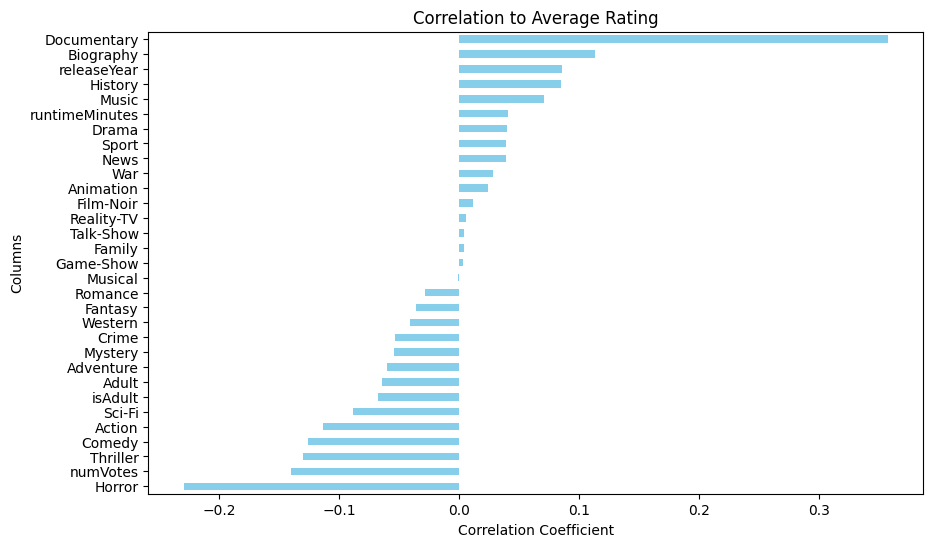

In [ ]:
correlation_matrix = movies.corr(method='spearman')
correlation_to_rating = correlation_matrix['averageRating']
plt.figure(figsize=(10, 6))
correlation_to_rating.drop('averageRating').sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation to Average Rating')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Columns')
plt.show()

**!!! nacitava cca 7**

In [ ]:
genre_ratings = {}
genre_p_values = {}

genres = set([val for val in set(movies['genres'].values)])
genres.discard('\\N')

for genre in genres:
    group1 = movies[movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]['averageRating']
    group2 = movies[~movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]['averageRating']

    if group1.shape[0] == 0:
        continue
    statistic, p_value = mannwhitneyu(group1, group2, alternative='greater')
    genre_p_values[genre] = p_value

    genre_movies = movies[movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]
    average_rating = genre_movies['averageRating'].mean()
    if not pd.isnull(average_rating):
        genre_ratings[genre] = average_rating

sorted_genres = sorted(genre_ratings, key=genre_ratings.get)

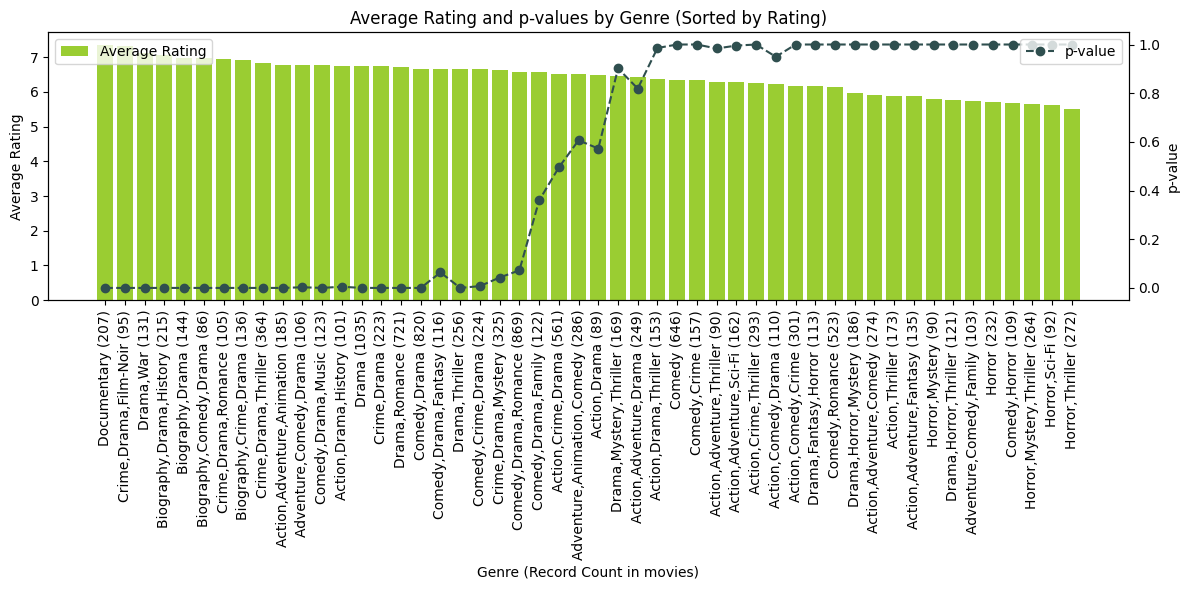

The average p-value is 0.467295837598409.


In [ ]:
sorted_genres = sorted(genre_ratings, key=genre_ratings.get)

# Vyberieme 50 žánrov s velkym poctom filmov
genre_counts = movies[movies['genres'].isin(genres) & (movies['numVotes'] > movies['numVotes'].mean())].groupby('genres').size().to_dict()
genres_to_display = dict(sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:50])
genres_to_display_with_count = [f'{genre} ({genre_counts.get(genre, 0)})' for genre in genres_to_display]

fig, ax1 = plt.subplots(figsize=(12, 6))

genres_sorted_by_rating = [genre for _, genre in sorted(zip([genre_ratings.get(genre, 0) for genre in genres_to_display], genres_to_display), reverse=True)]
genres_sorted_by_rating_counts = [genre_counts.get(genre, 0) for genre in genres_sorted_by_rating]
genres_sorted_by_rating_with_count = [f'{genre} ({count})' for genre, count in zip(genres_sorted_by_rating, genres_sorted_by_rating_counts)]

ax1.bar(range(len(genres_sorted_by_rating_with_count)), [genre_ratings.get(genre, 0) for genre in genres_sorted_by_rating], color='yellowgreen', label='Average Rating')
ax1.set_xlabel('Genre (Record Count in movies)')
ax1.set_ylabel('Average Rating')
ax1.set_title('Average Rating and p-values by Genre (Sorted by Rating)')
ax1.set_xticks(range(len(genres_sorted_by_rating_with_count)))
ax1.set_xticklabels(genres_sorted_by_rating_with_count, rotation=90)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(genres_sorted_by_rating_with_count)), [genre_p_values.get(genre, 0) for genre in genres_sorted_by_rating], marker='o', linestyle='--', color='darkslategray', label='p-value')
ax2.set_ylabel('p-value')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f'The average p-value is {sum(genre_p_values.values())/len(genre_p_values)}.')


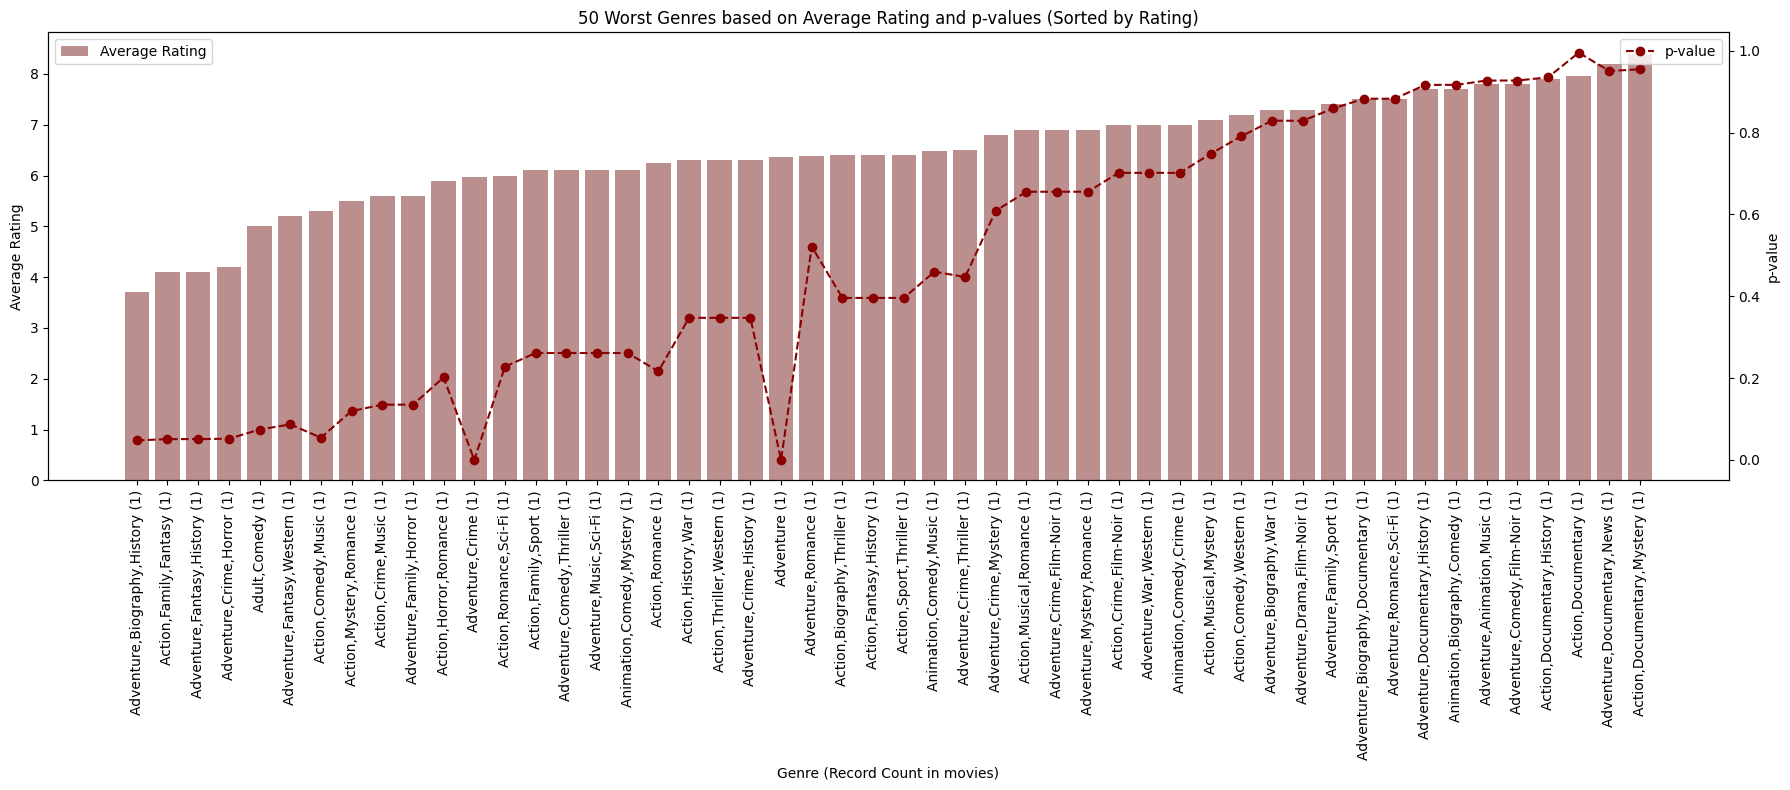

In [ ]:
# Vyberieme 50 žánrov s malým počtom filmov
worst_genres_to_display = dict(sorted(genre_counts.items(), key=lambda x: x[1])[:50])

worst_genres_sorted_by_rating = [genre for _, genre in sorted(zip([genre_ratings.get(genre, 0) for genre in worst_genres_to_display], worst_genres_to_display))]

genres_to_display_with_count_sorted = [f'{genre} ({genre_counts.get(genre, 0)})' for genre in worst_genres_sorted_by_rating]

fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.bar(range(len(genres_to_display_with_count_sorted)), [genre_ratings.get(genre, 0) for genre in worst_genres_sorted_by_rating], color='rosybrown', label='Average Rating')
ax1.set_xlabel('Genre (Record Count in movies)')
ax1.set_ylabel('Average Rating')
ax1.set_title('50 Worst Genres based on Average Rating and p-values (Sorted by Rating)')
ax1.set_xticks(range(len(genres_to_display_with_count_sorted)))
ax1.set_xticklabels(genres_to_display_with_count_sorted, rotation=90)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(genres_to_display_with_count_sorted)), [1 - genre_p_values.get(genre, 0) for genre in worst_genres_sorted_by_rating], marker='o', linestyle='--', color='darkred', label='p-value')
ax2.set_ylabel('p-value')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Vytvorenie váhovacieho faktora na základe logaritmu počtu hlasov a spočítanie
movies['WeightedRating'] = movies['averageRating'] * np.log(movies['numVotes'] + 1)
genre_weighted_average = movies.groupby('genres')['WeightedRating'].sum()

In [ ]:
genre_values = []
for genre in genres:
    genre_movies = movies[movies['genres'].str.contains(genre)]

    # Počet filmov v žánri
    num_movies = len(genre_movies)

    # Priemerný počet hlasov a priemerne hodnotenie pre žáner
    avg_num_votes = genre_movies['numVotes'].mean()
    avg_rating = genre_movies['averageRating'].mean()

    # Váhovanie hodnotenia na základe počtu hlasov
    genre_weighted_avg = genre_weighted_average[genre]

    # Pridanie do dát
    genre_values.append([genre, num_movies, avg_num_votes, avg_rating, genre_weighted_avg])

genre_values = pd.DataFrame(genre_values, columns=['Genre', 'NumMovies', 'AvgNumVotes', 'AvgRating', 'WeightedAvg'])
genre_values.head()


Genre  NumMovies  AvgNumVotes  AvgRating  WeightedAvg
0    Animation,Musical         18       86.056      5.856      239.657
1    Comedy,Sci-Fi,War          1      119.000      4.600       22.022
2    Crime,Drama,Music        158     4653.418      6.213     3365.720
3  Action,Drama,Family        126     4550.960      6.071     3416.436
4   History,Horror,War          1        6.000      8.000       15.567

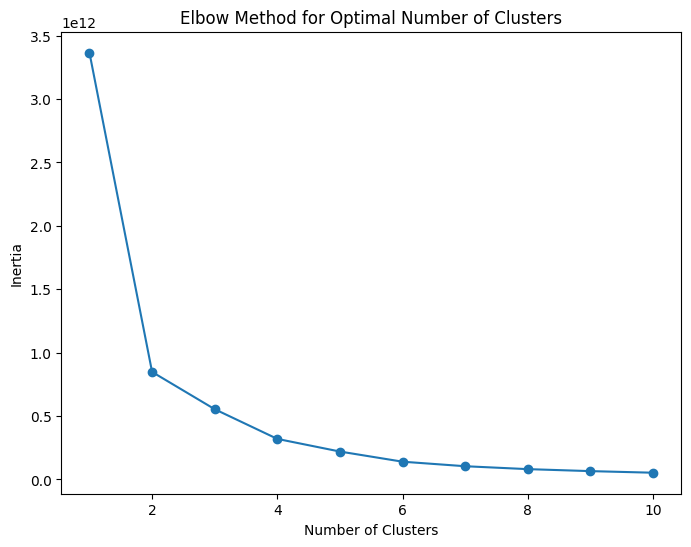

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



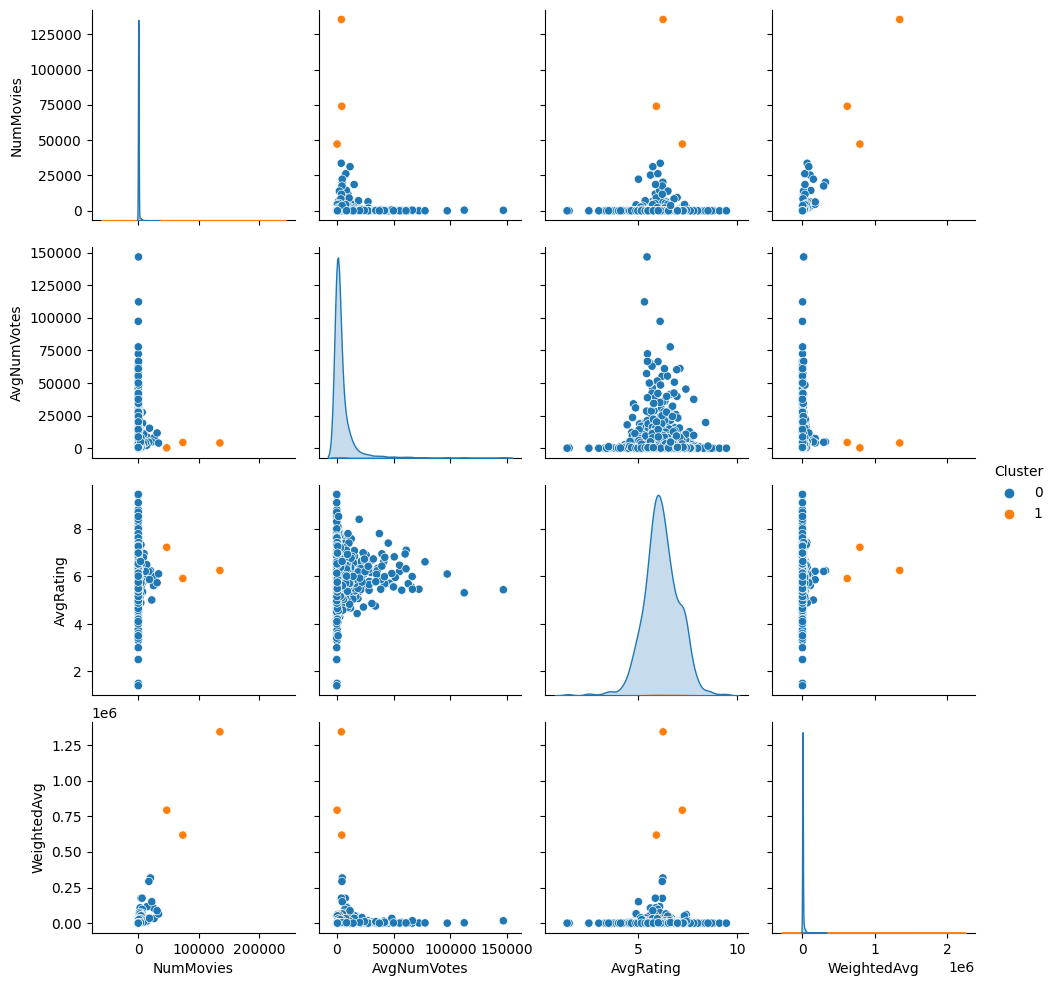

In [ ]:
data_for_clustering = genre_values[['NumMovies', 'AvgNumVotes', 'AvgRating', 'WeightedAvg']]

inertia = []

# Elbow method
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data_for_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Aplikácia K-means s optimálnym počtom klastrov
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k)
genre_values['Cluster'] = kmeans.fit_predict(data_for_clustering)

# Vizualizácia pomocou pairplot z knižnice seaborn
sns.pairplot(genre_values, hue='Cluster', vars=['NumMovies', 'AvgNumVotes', 'AvgRating', 'WeightedAvg'])
plt.show()

cluster_1 = genre_values[genre_values['Cluster'] == 0]
cluster_2 = genre_values[genre_values['Cluster'] == 1]

cluster_1 = set(cluster_1['Genre'])
cluster_2 = set(cluster_2['Genre'])

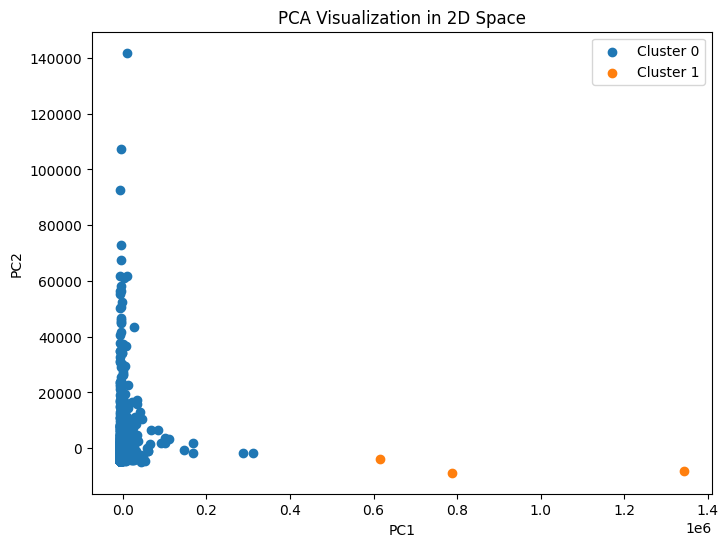

Explained Variance for PC1: 0.9536
Explained Variance for PC2: 0.0449
   NumMovies  AvgNumVotes  AvgRating  WeightedAvg
0      0.093        0.006      0.000        0.996
1     -0.001        1.000     -0.000       -0.005


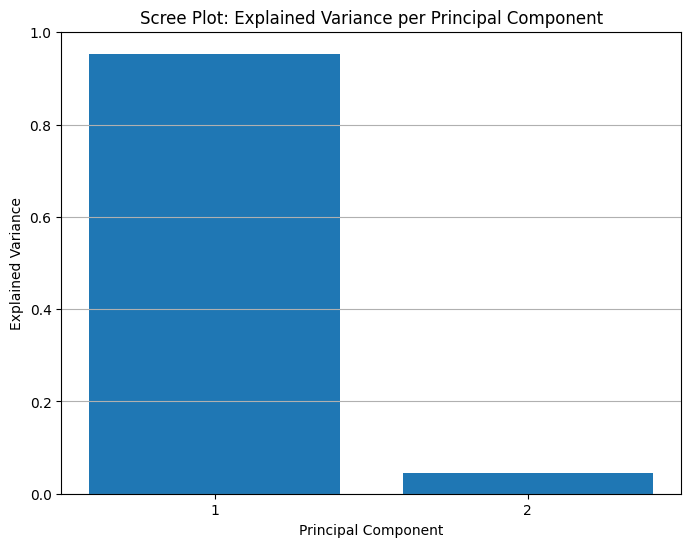

In [ ]:
data_for_pca = genre_values[['NumMovies', 'AvgNumVotes', 'AvgRating', 'WeightedAvg']]

# PCA with 2 principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_for_pca)
genre_values['PC1'] = pca_result[:, 0]
genre_values['PC2'] = pca_result[:, 1]

# Visualization of PCA in 2D space with color-coded clusters
plt.figure(figsize=(8, 6))
for cluster in genre_values['Cluster'].unique():
    cluster_data = genre_values[genre_values['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization in 2D Space')
plt.legend()
plt.show()

# Explained variance for each PC component
explained_variance = pca.explained_variance_ratio_
for i, ev in enumerate(explained_variance):
    print(f'Explained Variance for PC{i+1}: {ev:.4f}')

# Displaying the weights of columns for PC components
weights = pca.components_
weights_df = pd.DataFrame(weights, columns=data_for_pca.columns)
print(weights_df)

# Scree plot - Explained variance per principal component
plt.figure(figsize=(8, 6))
plt.bar(np.arange(1, len(explained_variance) + 1), explained_variance)
plt.title('Scree Plot: Explained Variance per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(axis='y')
plt.show()


In [ ]:
genre_data = pd.concat([genre_weighted_average], axis=1, keys=['WeightedAverage'])
sorted_genres = genre_data.sort_values(by='WeightedAverage', ascending=False)
top_genres = sorted_genres.head()
last_genres = sorted_genres.tail()
print("Most favorite genre's combination:")
print(top_genres)
print("\nLeast favorite genre's combination:")
print(last_genres)

combined_genres = pd.concat([top_genres, last_genres])

# Vytvorenie stĺpcového grafu
fig = px.bar(combined_genres, x=combined_genres.index, y='WeightedAverage',
             labels={'x': 'Genre Combinations', 'WeightedAverage': 'Weighted Average'},
             title='Most and Least Favorite Genre Combinations')

# Zobrazenie grafu
fig.show()

x_genres = list(top_genres['genres'])
top_genres = set(x_genres[:len(x_genres)])
last_genres = set(x_genres[len(x_genres):])

print(top_genres in cluster_1)

Most favorite genre's combination:
               WeightedAverage
genres                        
Drama              1342302.945
Documentary         792595.439
Comedy              617984.148
Comedy,Drama        317101.203
Drama,Romance       292847.349

Least favorite genre's combination:
                                WeightedAverage
genres                                         
Adventure,Horror,Musical                  7.884
Animation,Comedy,War                      7.728
Adult,Adventure,Horror                    7.455
Action,Adult,Fantasy                      6.412
Documentary,Mystery,Reality-TV            5.585


KeyError: 'genres'

In [ ]:
print(sorted_genres.mean())
print(sorted_genres.median())

In [ ]:
najoblubenejsi_zaner = genre_weighted_average.idxmax()
print(f"Najobľúbenejší žáner: {najoblubenejsi_zaner}")

najneoblubenejsi_zaner = genre_weighted_average.idxmin()
print(f"Najneobľúbenejší žáner: {najneoblubenejsi_zaner}")

Najobľúbenejší žáner: Drama
Najneobľúbenejší žáner: Documentary,Mystery,Reality-TV


In [ ]:
genres = set([x for val in set(movies['genres'].values) for x in val.split(',')])
genres.discard('\\N')


In [ ]:
for genre in genres:
  group1 = movies[movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]['averageRating']
  group2 = movies[~movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]['averageRating']

  if group1.shape[0]==0:
    continue
  statistic, p_value = mannwhitneyu(group1, group2, alternative='greater')
  print(genre, p_value)

News 2.089453938594119e-05
Film-Noir 8.786048387675938e-34
Fantasy 1.0
Romance 9.31172516236414e-08
Musical 2.7436068725195607e-07
Music 1.6136878727463016e-20
History 3.2236628581779826e-49
Documentary 5.002108956763695e-135
Biography 3.780814783539373e-91
Horror 1.0
Sci-Fi 1.0
Crime 0.001810574223992373
Action 1.0
Thriller 1.0
Sport 5.1901640957282634e-06
Western 1.1923253000302576e-08
Animation 5.792096963946027e-16
Drama 0.0
Adult 0.9257092392230661
War 5.9089113864793265e-46
Mystery 1.0
Family 0.9999993563203462
Adventure 0.9999999999569849
Comedy 1.0


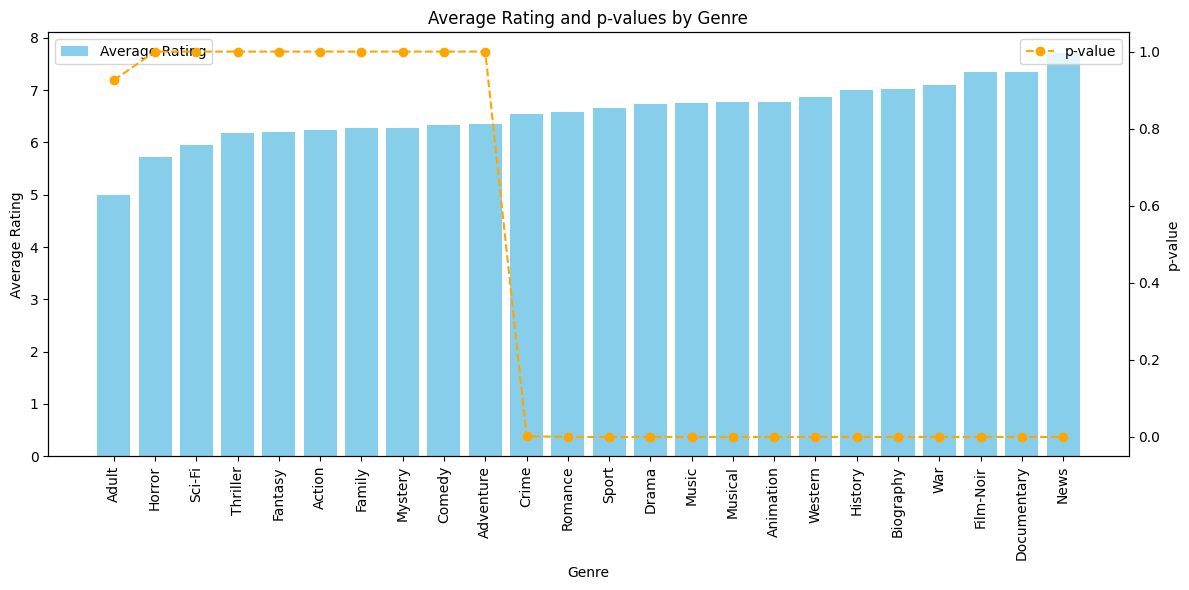

Kruskal-Wallis test:
Statistic: 5161.765399993086
P-value: 0.0


In [ ]:
genre_ratings = {}
genre_p_values = {}

for genre in genres:
    group1 = movies[movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]['averageRating']
    group2 = movies[~movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]['averageRating']

    if group1.shape[0] == 0:
        continue
    statistic, p_value = mannwhitneyu(group1, group2, alternative='greater')
    genre_p_values[genre] = p_value

    genre_movies = movies[movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]
    average_rating = genre_movies['averageRating'].mean()
    if not pd.isnull(average_rating):
        genre_ratings[genre] = average_rating

sorted_genres = sorted(genre_ratings, key=genre_ratings.get)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar([genre for genre in sorted_genres], [genre_ratings[genre] for genre in sorted_genres], color='skyblue', label='Average Rating')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Rating')
ax1.set_title('Average Rating and p-values by Genre')
ax1.tick_params(axis='x', rotation=90)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot([genre for genre in sorted_genres], [genre_p_values[genre] for genre in sorted_genres], marker='o', linestyle='--', color='orange', label='p-value')
ax2.set_ylabel('p-value')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Kruskal-Wallisov test porovnáva žánre a určuje,
# či existuje štatisticky významný rozdiel medzi ich strednými hodnotami.
# Výsledok je p-hodnota, ktorá udáva, či existuje rozdiel medzi aspoň 2 skupinami, ale nie priamo ktorými.

genre_ratings = {}
for genre in genres:
    genre_movies = movies[movies['genres'].str.contains(genre) & (movies['numVotes'] > movies['numVotes'].mean())]
    ratings = genre_movies['averageRating']

    if ratings.empty:
        continue

    genre_ratings[genre] = ratings

kruskal_result = kruskal(*[genre_ratings[genre] for genre in genre_ratings])

print("Kruskal-Wallis test:")
print(f"Statistic: {kruskal_result.statistic}")
print(f"P-value: {kruskal_result.pvalue}")


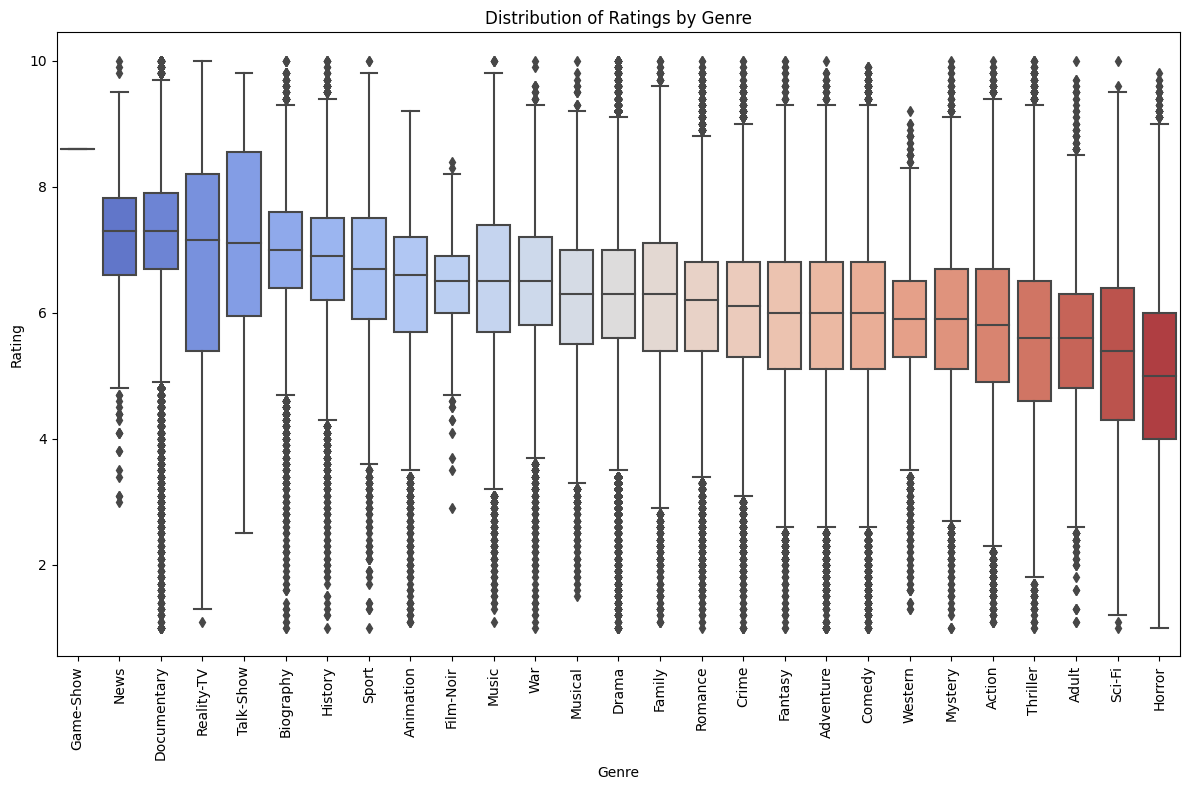

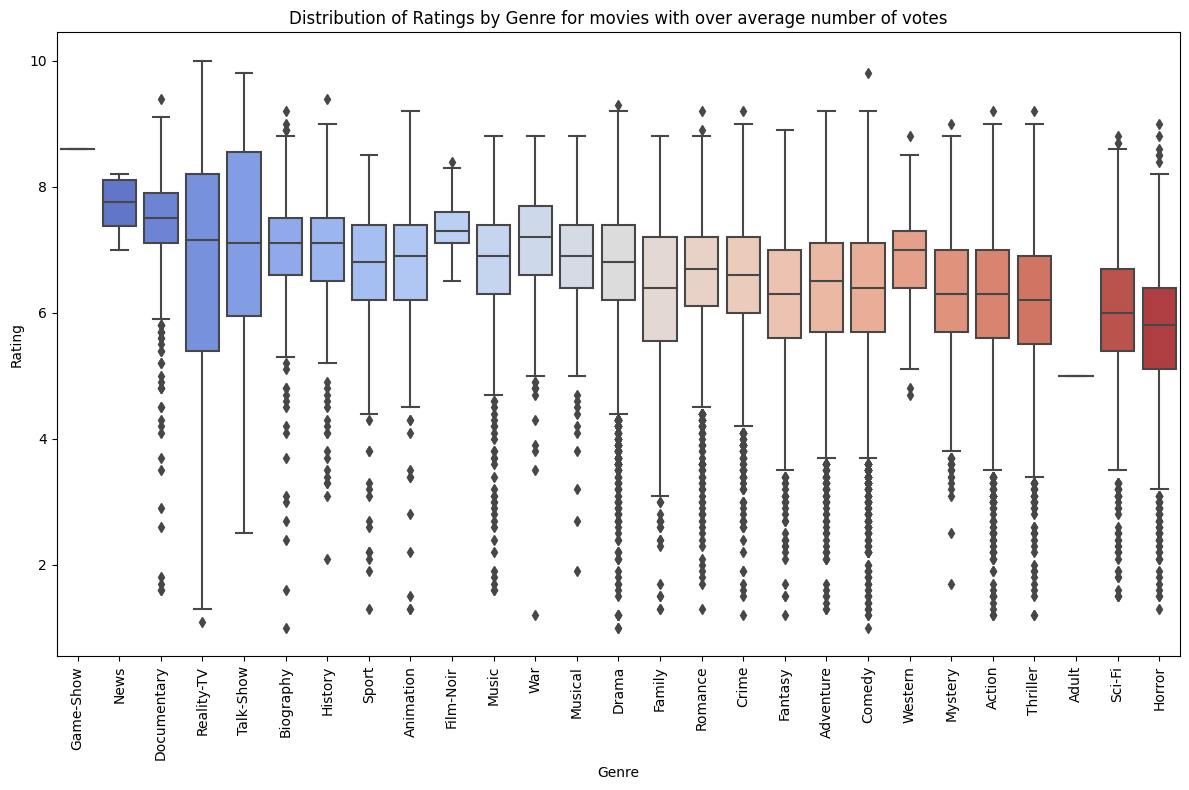

In [ ]:
genre_ratings = {}

for genre in genres:
    genre_movies = movies[movies['genres'].str.contains(genre)]

    if genre_movies.shape[0] == 0:
        continue

    ratings = genre_movies['averageRating']

    if not ratings.empty:
        genre_ratings[genre] = ratings

genre_names = list(genre_ratings.keys())
sorted_genres = sorted(genre_names, key=lambda x: genre_ratings[x].median(), reverse=True)

plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.DataFrame.from_dict(genre_ratings, orient='index').transpose(), order=sorted_genres, palette='coolwarm')
plt.title('Distribution of Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for genre in genres:
    genre_movies = movies[(movies['genres'].str.contains(genre)) & (movies['numVotes'] > movies['numVotes'].mean())]

    if genre_movies.shape[0] == 0:
        continue

    ratings = genre_movies['averageRating']

    if not ratings.empty:
        genre_ratings[genre] = ratings

plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.DataFrame.from_dict(genre_ratings, orient='index').transpose(), order=sorted_genres, palette='coolwarm')
plt.title('Distribution of Ratings by Genre for movies with over average number of votes')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## **Vplyv roku vydania filmov**

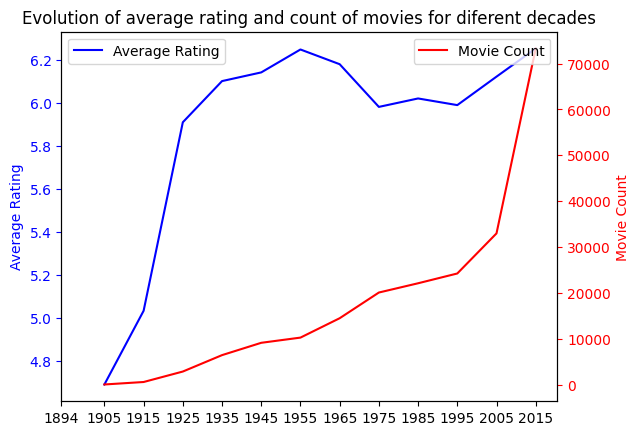

In [ ]:

x_ticks = sorted(set(movies['releaseYear'].values))[::10]

fig, ax1 = plt.subplots()

rolling_mean_rating = movies.groupby('releaseYear')['averageRating'].mean().rolling(window=10).mean()[::10]
rolling_count = movies.groupby('releaseYear').size().rolling(window=10).sum()[::10]

sns.lineplot(x=x_ticks, y=rolling_mean_rating.values, ax=ax1, label='Average Rating', color='b')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
sns.lineplot(x=x_ticks, y=rolling_count.values, ax=ax2, label='Movie Count', color='r')
ax2.set_ylabel('Movie Count', color='r')
ax2.tick_params('y', colors='r')
plt.title('Evolution of average rating and count of movies for diferent decades')

plt.xticks(x_ticks)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


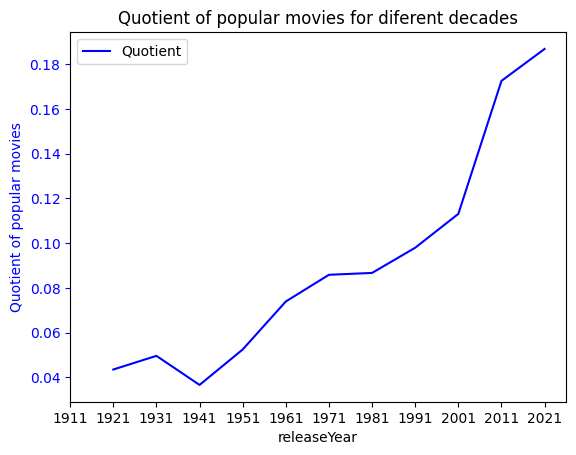

In [ ]:
fig, ax1 = plt.subplots()

first_high_rated_movie = movies[movies['averageRating'] > 7.5]['releaseYear'].min()
filtered_movies = movies[movies['releaseYear'] >= first_high_rated_movie]
rolling_count = filtered_movies.groupby('releaseYear').size().rolling(window=10).sum()[::10]
rolling_popular = filtered_movies[filtered_movies['averageRating'] > 7.5].groupby('releaseYear').size().rolling(window=10).sum()[::10]

y = rolling_popular/rolling_count

sns.lineplot(x=y.index, y=y, ax=ax1, label='Quotient', color='b')
ax1.set_ylabel('Quotient of popular movies', color='b')
ax1.tick_params('y', colors='b')
plt.title('Quotient of popular movies for diferent decades')


plt.xticks(y.index)

ax1.legend(loc='upper left')

plt.show()

## **Vplyv dĺžky filmu**

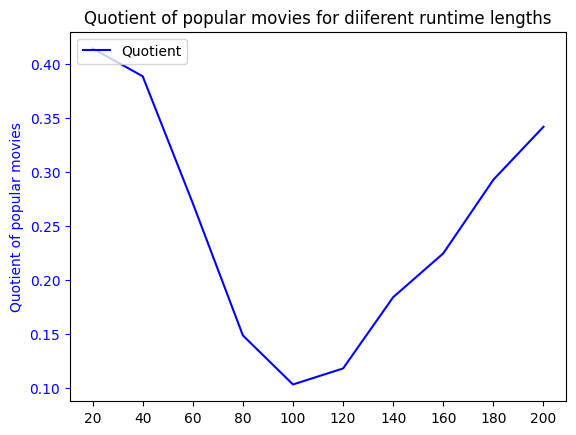

In [ ]:
bins = list(range(0, 210, 20))
movies['runtimeInterval'] = pd.cut(movies['runtimeMinutes'], bins)

fig, ax1 = plt.subplots()

rolling_count = movies.groupby('runtimeInterval').size()
rolling_popular = movies[movies['averageRating'] > 7.5].groupby('runtimeInterval').size()
y = rolling_popular/rolling_count
sns.lineplot(x=bins[1:], y=y, ax=ax1, label='Quotient', color='b')
ax1.set_ylabel('Quotient of popular movies', color='b')
ax1.tick_params('y', colors='b')
plt.xticks(bins[1:])
plt.title('Quotient of popular movies for diiferent runtime lengths')


ax1.legend(loc='upper left')

plt.show()

## **PCA**

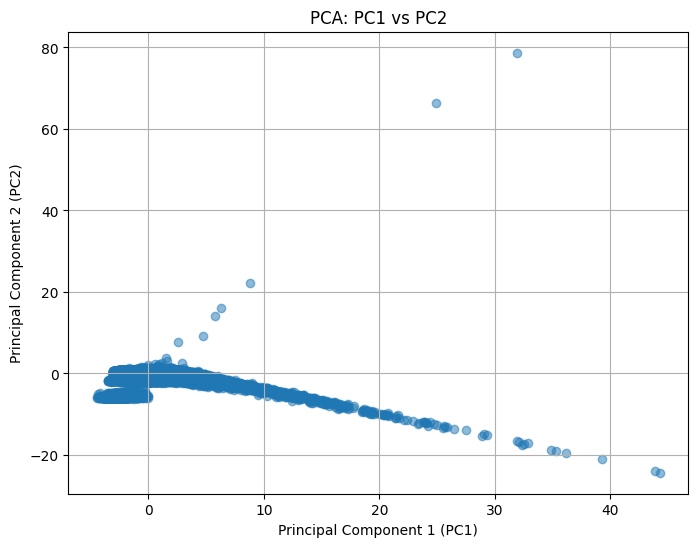

Explained Variance for PC1: 0.2655
Explained Variance for PC2: 0.1754
Explained Variance for PC3: 0.1660
   isAdult  releaseYear  runtimeMinutes  averageRating  numVotes  \
0   -0.172        0.137           0.085          0.484     0.514   
1   -0.649        0.639           0.211          0.079    -0.318   
2    0.197       -0.044           0.956         -0.191     0.098   

   WeightedRating  
0           0.668  
1          -0.137  
2           0.001  


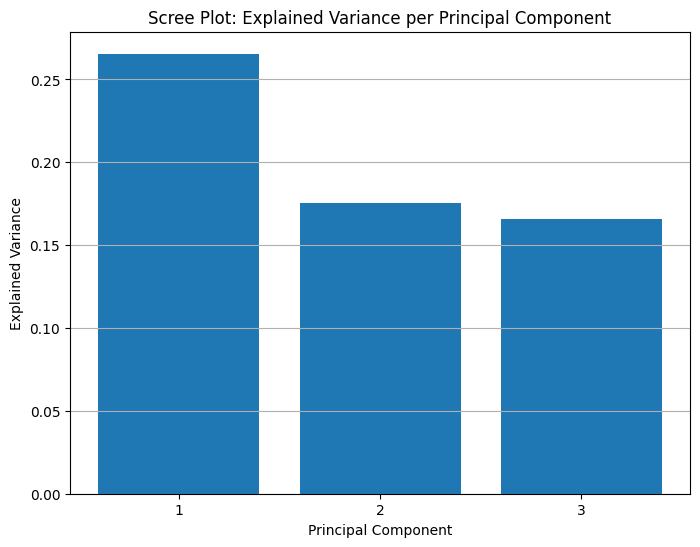

In [ ]:
numeric_columns = movies.select_dtypes(include=['float64', 'int64']).dropna()
#numeric_columns = movies.select_dtypes(include=['float64', 'int64', 'uint8']).dropna() # aj zanre
# Normalizácia dát
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

# 2D vizualizácia
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA: PC1 vs PC2')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()

# pc1 - pc3 analysis
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.5)
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
# plt.title('PCA Results in 3D')
# plt.show()

explained_variance = pca.explained_variance_ratio_
for i, ev in enumerate(explained_variance):
    print(f'Explained Variance for PC{i+1}: {ev:.4f}')

# zobrazenie váh stĺpcov pre jednotlivé hlavné komponenty
weights = pca.components_
weights_df = pd.DataFrame(weights, columns=numeric_columns.columns)
print(weights_df)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(np.arange(1, len(explained_variance) + 1), explained_variance)
plt.title('Scree Plot: Explained Variance per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(axis='y')
plt.show()

## **Analýza: Režiséri a scénaristi**

In [ ]:
print("Missing directors: ", movies['directors'].isna().sum())
print("Missing writers: ", movies['writers'].isna().sum())

directors_list = movies['directors'].dropna()
all_directors = []
for directors in directors_list:
  for director in directors.split(','):
      all_directors.append(director)
all_directors = pd.Series(all_directors)

print()
unique_directors = len(all_directors.unique())
print("Unique directors:", unique_directors)
print("Total count of directors in movies:", len(all_directors))

ratio_unique_to_all = unique_directors / len(all_directors)
print("Ratio of unique to all directors:", round(ratio_unique_to_all, 2))

print()
writers_list = movies['writers'].dropna()
all_writers = []
for writers in writers_list:
  for writer in writers.split(','):
      all_writers.append(writer)
all_writers = pd.Series(all_writers)

unique_writers = len(all_writers.unique())
print("Unique writers:", unique_writers)
print("Total count of writers in movies:", len(all_writers))

ratio_unique_to_all = unique_writers / len(all_writers)
print("Ratio of unique to all writers:", round(ratio_unique_to_all, 2))

Missing directors:  2854
Missing writers:  34420

Unique directors: 132101
Total count of directors in movies: 329946
Ratio of unique to all directors: 0.4

Unique writers: 207213
Total count of writers in movies: 497623
Ratio of unique to all writers: 0.42


In [ ]:
all_directors_counts = all_directors.value_counts().rename_axis('nconst').reset_index(name='number of directed movies')
merged_all_directors_counts = pd.merge(all_directors_counts, directors_writers[['nconst', 'primaryName']], on='nconst', how='left')
cols = merged_all_directors_counts.columns.tolist()
merged_all_directors_counts = merged_all_directors_counts[[cols[0], cols[2], cols[1]]]
print(merged_all_directors_counts.shape)
merged_all_directors_counts.head(n=10)

(132101, 3)


nconst                primaryName  number of directed movies
0  nm0627864               Sam Newfield                        203
1  nm0001238               Jesús Franco                        185
2  nm0002031             Michael Curtiz                        155
3  nm0064415           William Beaudine                        148
4  nm0554924  Gilberto Martínez Solares                        142
5  nm0782947            Lesley Selander                        133
6  nm0484645                Lew Landers                        132
7  nm0781261             Osman F. Seden                        130
8  nm0061792                 Godfrey Ho                        129
9  nm0861703             Richard Thorpe                        127

In [ ]:
print("Count of unknown director names: ", merged_all_directors_counts['primaryName'].isna().sum())

Count of unknown director names:  0


In [ ]:
all_writers_counts = all_writers.value_counts().rename_axis('nconst').reset_index(name='number of written movies')
merged_all_writers_counts = pd.merge(all_writers_counts, directors_writers[['nconst', 'primaryName']], on='nconst', how='left')
cols = merged_all_writers_counts.columns.tolist()
merged_all_writers_counts = merged_all_writers_counts[[cols[0], cols[2], cols[1]]]
print(merged_all_writers_counts.shape)
merged_all_writers_counts.head(n=10)

(207213, 3)


nconst                 primaryName  number of written movies
0  nm0000636         William Shakespeare                       394
1  nm0960106                   Safa Önal                       288
2  nm0876561               Erdogan Tünas                       261
3  nm0649320                 Bülent Oran                       251
4  nm0393250                    Kuang Ni                       212
5  nm0939147                   Jing Wong                       200
6  nm0302055            Fernando Galiana                       171
7  nm0001238                Jesús Franco                       167
8  nm0664085  Paruchuri Venkateswara Rao                       149
9  nm0664084     Gopalakrishna Paruchuri                       149

In [ ]:
print("Count of unknown writer names: ", merged_all_writers_counts['primaryName'].isna().sum())

Count of unknown writer names:  0


In [ ]:
# direktormi vlastne napisaneho scenara
director_counts = {}
movies_subframe = movies[['directors', 'writers']].copy()
movies_subframe.dropna(inplace=True)

movies_subframe.reset_index()
for index, row in movies_subframe.iterrows():
    directors_set = row['directors'].split(',')
    writers_set = row['writers'].split(',')

    for director in directors_set:
        if director in writers_set:
            director_counts[director] = director_counts.get(director, 0) + 1

director_counts_df = pd.DataFrame(list(director_counts.items()), columns=['nconst', 'count'])
director_counts = pd.merge(director_counts_df, directors_writers[['nconst', 'primaryName']], on='nconst', how='left')
cols = director_counts.columns.tolist()
director_counts = director_counts[[cols[0], cols[2], cols[1]]]
director_counts.sort_values(by=['count'], ascending=False)

nconst                primaryName  count
3259   nm0001238               Jesús Franco    151
9947   nm0939147                  Jing Wong    107
1588   nm0554924  Gilberto Martínez Solares     88
3297   nm0654839             Mariano Ozores     84
4036   nm0945282                Yôji Yamada     84
...          ...                        ...    ...
40706  nm2356371               Lev Anderson      1
40707  nm1311302                Cyril Sebas      1
40708  nm2964475               Alex Knudsen      1
40709  nm8287080        Mizanur Rahman Dipu      1
86612  nm7339841         Eric Rafael Ibarra      1

[86613 rows x 3 columns]

# **Populárne a nepopulárne filmy**

## **Selekcia dát**

In [ ]:
movies_sorted = movies.sort_values(by='averageRating', ascending=False)
mean_num_votes = movies_sorted['numVotes'].mean()

filtered_movies = movies_sorted[movies_sorted['numVotes'] > mean_num_votes]

total_count = len(filtered_movies)
nonpopular_movies = filtered_movies.iloc[int(0.75 * total_count):]
popular_movies = filtered_movies.iloc[:int(0.25 * total_count)]

nonpopular_movies.to_csv('nonpopular_movies.csv', index=False)
popular_movies.to_csv('popular_movies.csv', index=False)

### **Producenti a scénáristi pri obľúbených a neobľúbených filmoch**

In [ ]:
nonpop_movies_filtered = nonpop_movies[['tconst', 'primaryTitle', 'releaseYear', 'averageRating', 'budget', 'grossWorldwide']].copy()
pop_movies_filtered = pop_movies[['tconst', 'primaryTitle', 'releaseYear', 'averageRating', 'budget', 'grossWorldwide']].copy()
nonpop_movies_m = pd.merge(nonpop_movies_filtered, movies[['tconst', 'directors', 'writers']], on='tconst', how='left')
pop_movies_m = pd.merge(pop_movies_filtered, movies[['tconst', 'directors', 'writers']], on='tconst', how='left')
display(nonpop_movies_m.head())
print("NaNs nonpopular: directors ", nonpop_movies_m['directors'].isna().sum(), "writers ", nonpop_movies_m['writers'].isna().sum())
print("NaNs popular: directors ", pop_movies_m['directors'].isna().sum(), "writers ", pop_movies_m['writers'].isna().sum())

tconst                    primaryTitle  releaseYear  averageRating  \
0   tt0094057                    Street Trash     1987.000          5.900   
1  tt11586384               Masking Threshold     2021.000          5.900   
2   tt3469244                         Phantom     2015.000          5.900   
3   tt9026524                           Bliss     2019.000          5.900   
4   tt1649780  Peace, Love & Misunderstanding     2011.000          5.900   

       budget  grossWorldwide  directors  \
0  457000.000             NaN  nm0614013   
1         NaN             NaN  nm3654931   
2 6855000.000    12500403.260  nm1203138   
3         NaN             NaN  nm3976308   
4 9140000.000     1009988.280  nm0000915   

                                   writers  
0                      nm0296689,nm0614013  
1                     nm3654931,nm11547029  
2  nm1583746,nm1203138,nm5151578,nm3613395  
3                                nm3976308  
4                      nm3898253,nm3895605

NaNs nonpopular: directors  0 writers  12
NaNs popular: directors  0 writers  175


In [ ]:
# select unique directors and writers from pop and nonpop movies
directors_nonpop_list = nonpop_movies_m['directors']
directors_nonpop = []
for directors in directors_nonpop_list:
  for director in directors.split(','):
      directors_nonpop.append(director)
directors_nonpop = pd.Series(directors_nonpop)

writers_nonpop_list = nonpop_movies_m['writers'].dropna()
writers_nonpop = []
for writers in writers_nonpop_list:
  for writer in writers.split(','):
      writers_nonpop.append(writer)
writers_nonpop = pd.Series(writers_nonpop)

directors_pop_list = pop_movies_m['directors']
directors_pop = []
for directors in directors_pop_list:
  for director in directors.split(','):
      directors_pop.append(director)
directors_pop = pd.Series(directors_pop)

writers_pop_list = pop_movies_m['writers'].dropna()
writers_pop = []
for writers in writers_pop_list:
  for writer in writers.split(','):
      writers_pop.append(writer)
writers_pop = pd.Series(writers_pop)

# directors nonpop movie count
print("directors nonpop movie count")
directors_nonpop_count = directors_nonpop.value_counts().rename_axis('nconst').reset_index(name='number of directed movies')
merged_directors_nonpop_count = pd.merge(directors_nonpop_count, directors_writers[['nconst', 'primaryName']], on='nconst', how='left')
cols = merged_directors_nonpop_count.columns.tolist()
merged_directors_nonpop_count = merged_directors_nonpop_count[[cols[0], cols[2], cols[1]]]
print(merged_directors_nonpop_count.shape)
display(merged_directors_nonpop_count.head())

# writers nonpop movie count
print("writers nonpop movie count")
writers_nonpop_count = writers_nonpop.value_counts().rename_axis('nconst').reset_index(name='number of directed movies')
merged_writers_nonpop_count = pd.merge(writers_nonpop_count, directors_writers[['nconst', 'primaryName']], on='nconst', how='left')
cols = merged_writers_nonpop_count.columns.tolist()
merged_writers_nonpop_count = merged_writers_nonpop_count[[cols[0], cols[2], cols[1]]]
print(merged_writers_nonpop_count.shape)
display(merged_writers_nonpop_count.head())

# directors pop movie count
print("directors pop movie count")
directors_pop_count = directors_pop.value_counts().rename_axis('nconst').reset_index(name='number of directed movies')
merged_directors_pop_count = pd.merge(directors_pop_count, directors_writers[['nconst', 'primaryName']], on='nconst', how='left')
cols = merged_directors_pop_count.columns.tolist()
merged_directors_pop_count = merged_directors_pop_count[[cols[0], cols[2], cols[1]]]
print(merged_directors_pop_count.shape)
display(merged_directors_pop_count.head())

# writers pop movie count
print("writers pop movie count")
writers_pop_count = writers_pop.value_counts().rename_axis('nconst').reset_index(name='number of directed movies')
merged_writers_pop_count = pd.merge(writers_pop_count, directors_writers[['nconst', 'primaryName']], on='nconst', how='left')
cols = merged_writers_pop_count.columns.tolist()
merged_writers_pop_count = merged_writers_pop_count[[cols[0], cols[2], cols[1]]]
print(merged_writers_pop_count.shape)
display(merged_writers_pop_count.head())

directors nonpop movie count
(3642, 3)


nconst     primaryName  number of directed movies
0  nm1347153     Tyler Perry                         18
1  nm0001317    Renny Harlin                         12
2  nm0093051        Uwe Boll                         10
3  nm0000127      Wes Craven                         10
4  nm2204103  Togan Gökbakar                          9

writers nonpop movie count
(7998, 3)


nconst   primaryName  number of directed movies
0  nm2260872  Farhad Samji                         24
1  nm0000175  Stephen King                         23
2  nm1347153   Tyler Perry                         19
3  nm2678319         Sajid                         16
4  nm0000127    Wes Craven                         14

directors pop movie count
(2883, 3)


nconst       primaryName  number of directed movies
0  nm0000033  Alfred Hitchcock                         23
1  nm0000005    Ingmar Bergman                         22
2  nm0000229  Steven Spielberg                         21
3  nm0000041    Akira Kurosawa                         21
4  nm0000217   Martin Scorsese                         20

writers pop movie count
(7428, 3)


nconst          primaryName  number of directed movies
0  nm0372942            Ben Hecht                         25
1  nm0000636  William Shakespeare                         24
2  nm0000041       Akira Kurosawa                         24
3  nm0000005       Ingmar Bergman                         21
4  nm0000095          Woody Allen                         19

In [ ]:
sum_rating_npd = pd.DataFrame(columns=['nconst', 'total_rating', 'count'])

for i, row in nonpop_movies_m.iterrows():
    directors = row['directors'].split(',')
    rating = row['averageRating']

    data_to_append = []

    for director in directors:
        director_id = director.strip()
        if director_id not in sum_rating_npd['nconst'].values:
            data_to_append.append({'nconst': director_id, 'total_rating': rating, 'count': 1})
        else:
            sum_rating_npd.loc[sum_rating_npd['nconst'] == director_id, 'total_rating'] += rating
            sum_rating_npd.loc[sum_rating_npd['nconst'] == director_id, 'count'] += 1

    if data_to_append:
        sum_rating_npd = pd.concat([sum_rating_npd, pd.DataFrame(data_to_append)], ignore_index=True)

sum_rating_ppd = pd.DataFrame(columns=['nconst', 'total_rating', 'count'])

for i, row in pop_movies_m.iterrows():
    directors = row['directors'].split(',')
    rating = row['averageRating']

    data_to_append = []

    for director in directors:
        director_id = director.strip()
        if director_id not in sum_rating_ppd['nconst'].values:
            data_to_append.append({'nconst': director_id, 'total_rating': rating, 'count': 1})
        else:
            sum_rating_ppd.loc[sum_rating_ppd['nconst'] == director_id, 'total_rating'] += rating
            sum_rating_ppd.loc[sum_rating_ppd['nconst'] == director_id, 'count'] += 1

    if data_to_append:
        sum_rating_ppd = pd.concat([sum_rating_ppd, pd.DataFrame(data_to_append)], ignore_index=True)

sum_rating_npw = pd.DataFrame(columns=['nconst', 'total_rating', 'count'])

for i, row in nonpop_movies_m.iterrows():
    try:
      directors = row['writers'].split(',')
      rating = row['averageRating']

      data_to_append = []

      for director in directors:
          director_id = director.strip()
          if director_id not in sum_rating_npw['nconst'].values:
              data_to_append.append({'nconst': director_id, 'total_rating': rating, 'count': 1})
          else:
              sum_rating_npw.loc[sum_rating_npw['nconst'] == director_id, 'total_rating'] += rating
              sum_rating_npw.loc[sum_rating_npw['nconst'] == director_id, 'count'] += 1

      if data_to_append:
          sum_rating_npw = pd.concat([sum_rating_npw, pd.DataFrame(data_to_append)], ignore_index=True)
    except AttributeError:
      pass

sum_rating_ppw = pd.DataFrame(columns=['nconst', 'total_rating', 'count'])

for i, row in pop_movies_m.iterrows():
    try:
      directors = row['writers'].split(',')
      rating = row['averageRating']

      data_to_append = []

      for director in directors:
          director_id = director.strip()
          if director_id not in sum_rating_ppw['nconst'].values:
              data_to_append.append({'nconst': director_id, 'total_rating': rating, 'count': 1})
          else:
              sum_rating_ppw.loc[sum_rating_ppw['nconst'] == director_id, 'total_rating'] += rating
              sum_rating_ppw.loc[sum_rating_ppw['nconst'] == director_id, 'count'] += 1

      if data_to_append:
          sum_rating_ppw = pd.concat([sum_rating_ppw, pd.DataFrame(data_to_append)], ignore_index=True)
    except AttributeError:
      pass

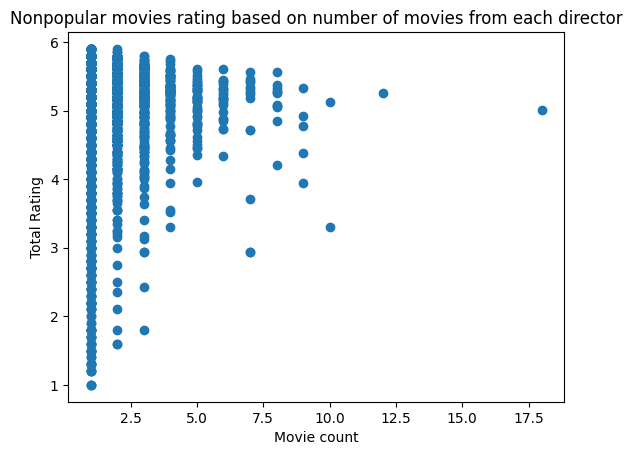


Correlation for nonpopular movies rating based on number of movies from each director:
                           total_rating  number of directed movies
total_rating                      1.000                      0.978
number of directed movies         0.978                      1.000


<ipython-input-95-2d2a4be458c4>:11: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



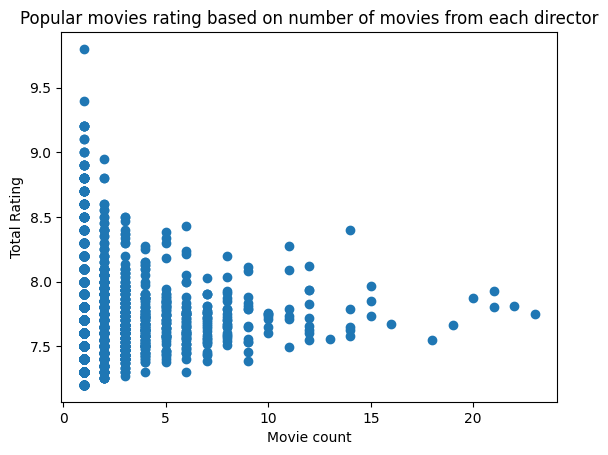


Correlation for popular movies rating based on number of movies from each director:
                           total_rating  number of directed movies
total_rating                      1.000                      0.999
number of directed movies         0.999                      1.000


<ipython-input-95-2d2a4be458c4>:23: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



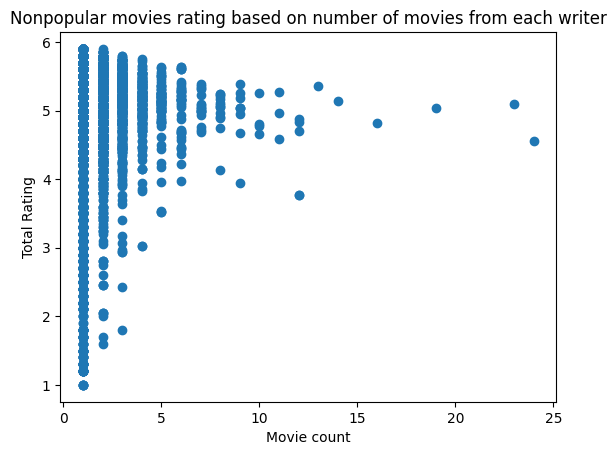


Correlation for nonpopular movies rating based on number of movies from each writer:
                           total_rating  number of directed movies
total_rating                      1.000                      0.982
number of directed movies         0.982                      1.000


<ipython-input-95-2d2a4be458c4>:35: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



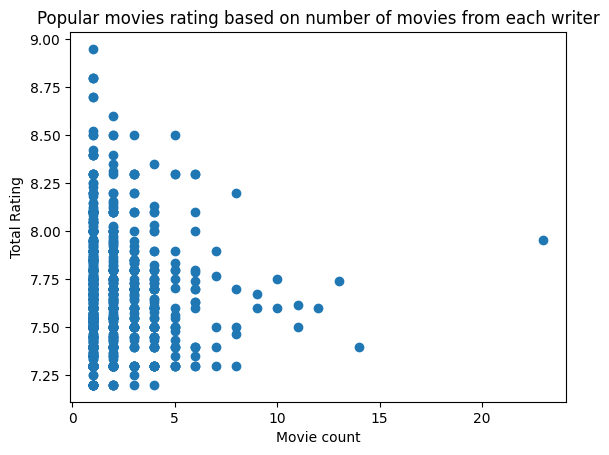


Correlation for popular movies rating based on number of movies from each director:
                           total_rating  number of directed movies
total_rating                      1.000                      0.091
number of directed movies         0.091                      1.000


<ipython-input-95-2d2a4be458c4>:47: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [ ]:
npd = pd.merge(sum_rating_npd, merged_directors_nonpop_count, on='nconst', how='left')
npd['AVG'] = npd['total_rating']/npd['count']
plt.scatter(npd['number of directed movies'], npd['AVG'])
plt.title('Nonpopular movies rating based on number of movies from each director')
plt.xlabel('Movie count')
plt.ylabel('Total Rating')
plt.show()

print()
print('Correlation for nonpopular movies rating based on number of movies from each director:')
print(npd.corr())

npd = pd.merge(sum_rating_ppd, merged_directors_pop_count, on='nconst', how='left')
npd['AVG'] = npd['total_rating']/npd['count']
plt.scatter(npd['number of directed movies'], npd['AVG'])
plt.title('Popular movies rating based on number of movies from each director')
plt.xlabel('Movie count')
plt.ylabel('Total Rating')
plt.show()

print()
print('Correlation for popular movies rating based on number of movies from each director:')
print(npd.corr())

npd = pd.merge(sum_rating_npw, merged_writers_nonpop_count, on='nconst', how='left')
npd['AVG'] = npd['total_rating']/npd['count']
plt.scatter(npd['number of directed movies'], npd['AVG'])
plt.title('Nonpopular movies rating based on number of movies from each writer')
plt.xlabel('Movie count')
plt.ylabel('Total Rating')
plt.show()

print()
print('Correlation for nonpopular movies rating based on number of movies from each writer:')
print(npd.corr())

npd = pd.merge(sum_rating_ppw, merged_writers_nonpop_count, on='nconst', how='left')
npd['AVG'] = npd['total_rating']/npd['count']
plt.scatter(npd['number of directed movies'], npd['AVG'])
plt.title('Popular movies rating based on number of movies from each writer')
plt.xlabel('Movie count')
plt.ylabel('Total Rating')
plt.show()

print()
print('Correlation for popular movies rating based on number of movies from each director:')
print(npd.corr())

## **Výskyt slov v názvoch filmov**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


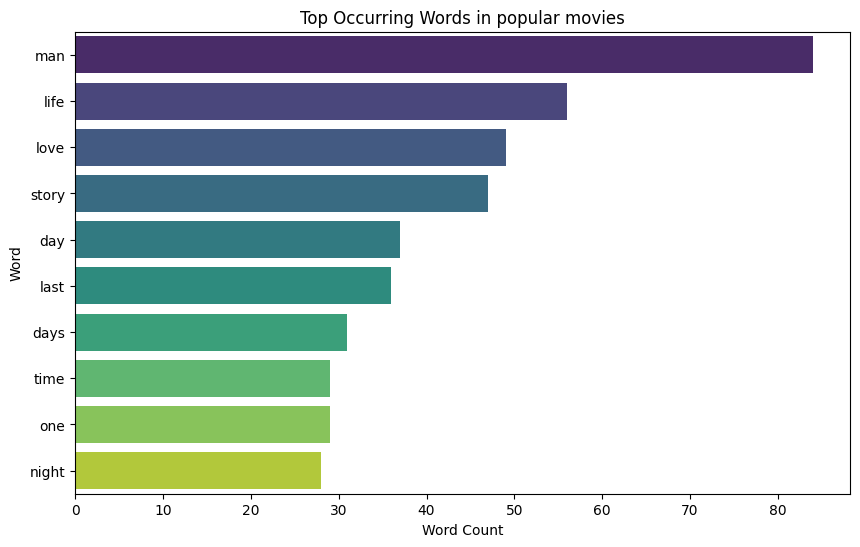

In [ ]:
nltk.download('stopwords')
english_stopwords = list(stopwords.words('english'))
english_stopwords.append('de')
english_stopwords.append('la')
english_stopwords.append('el')
vectorizer = CountVectorizer(stop_words=english_stopwords)
X = vectorizer.fit_transform(popular_movies['primaryTitle'])
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
total_word_counts = word_counts.sum(axis=0)
top_words = total_word_counts.sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')
plt.title('Top Occurring Words in popular movies')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()

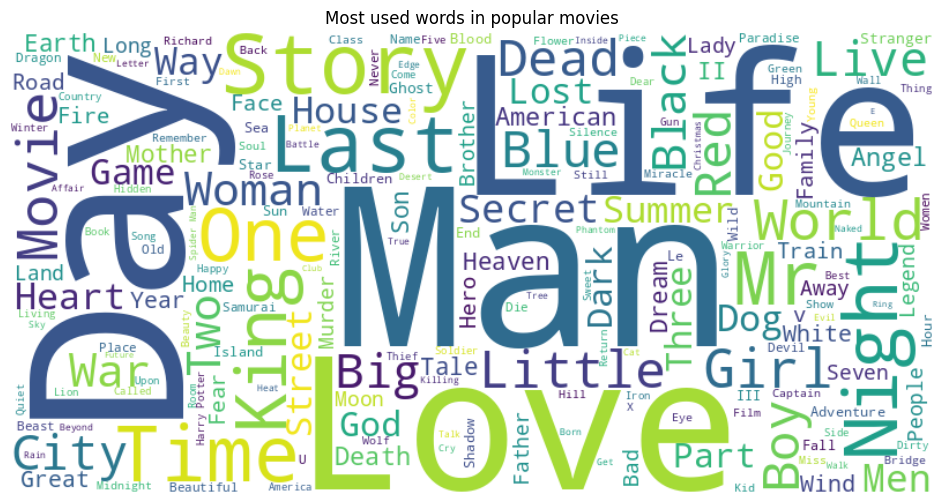

In [ ]:

all_descriptions = ' '.join(popular_movies['primaryTitle'])

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=english_stopwords).generate(all_descriptions)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most used words in popular movies')
plt.show()


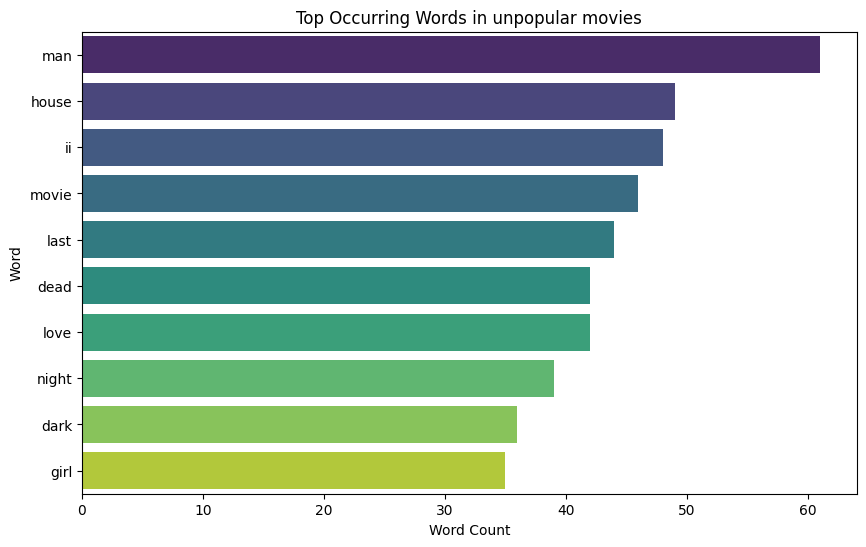

In [ ]:
vectorizer = CountVectorizer(stop_words=english_stopwords)
X = vectorizer.fit_transform(nonpopular_movies['primaryTitle'])
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
total_word_counts = word_counts.sum(axis=0)
top_words = total_word_counts.sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')
plt.title('Top Occurring Words in unpopular movies')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()

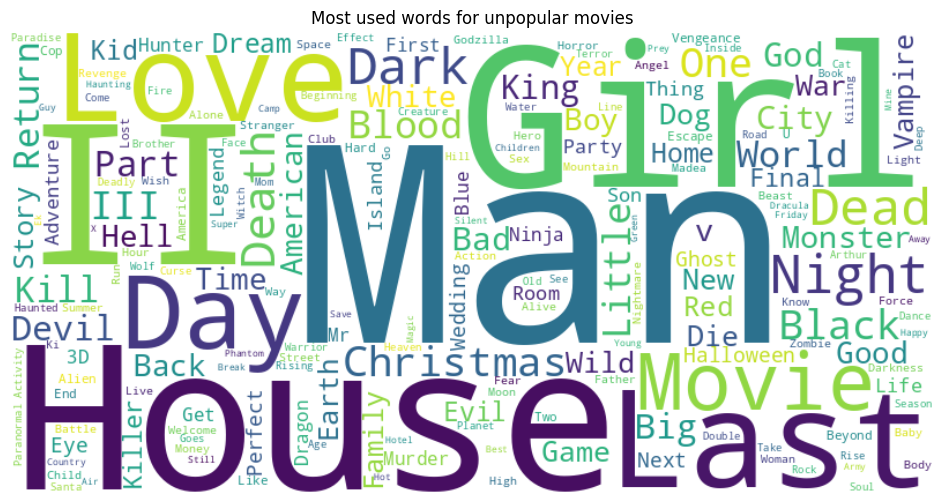

In [ ]:
all_descriptions = ' '.join(nonpopular_movies['primaryTitle'])

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=english_stopwords).generate(all_descriptions)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most used words for unpopular movies')
plt.show()

## **Logistická regresia**




In [ ]:
pop_movies['success'] = 1
nonpop_movies['success'] = 0

merged = pd.concat([pop_movies, nonpop_movies], ignore_index=True)
merged_df = pd.merge(merged, movies[['directors', 'writers', 'tconst']], on='tconst')
ordinal_mapping = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe':3}


genres_split = merged_df['genres'].str.split(',', expand=True)
genres_encoded = pd.get_dummies(genres_split, prefix='', prefix_sep='').max(level=0, axis=1)
merged_df = pd.concat([merged_df, genres_encoded], axis=1)
merged_df['nudity'] = merged_df['nudity'].map(ordinal_mapping)
merged_df['violence'] = merged_df['violence'].map(ordinal_mapping)
merged_df['profanity'] = merged_df['profanity'].map(ordinal_mapping)
merged_df['alcohol'] = merged_df['alcohol'].map(ordinal_mapping)
merged_df['frightening'] = merged_df['frightening'].map(ordinal_mapping)

<ipython-input-100-0c8ada6a6e52>:10: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



In [ ]:
from sklearn.model_selection import train_test_split
all_columns = ['primaryTitle', 'genres', 'actors', 'productionCompanies','countriesOfOrigin', 'directors', 'writers']

def evaluate_model(data, columns):
    data['combined'] = data[columns].apply(lambda row: ' '.join(map(str, row)), axis=1)
    training, test = train_test_split(data, test_size=0.2, random_state=1)
    y_train = training['success']
    y_test = test['success']
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(training['combined'])
    reg = LogisticRegression(max_iter=200).fit(X_train, y_train)
    X_test = vectorizer.transform(test['combined'])
    y_pred = reg.predict(X_test)
    return f1_score(y_test, y_pred)

excluded_columns_list = [[],['primaryTitle'], ['genres'], ['actors'], ['productionCompanies'],['countriesOfOrigin'], ['directors'], ['writers']]
for excluded_columns in excluded_columns_list:
    cols = list(set(all_columns) - set(excluded_columns))
    f1 = evaluate_model(merged_df, cols)
    print(f'Columns excluded: {excluded_columns}, F1 Score: {f1}')
print('The biggest impact has the genre as the difference in F1 scores is the most dramatic')

Columns excluded: [], F1 Score: 0.8533872598584429
Columns excluded: ['primaryTitle'], F1 Score: 0.8544080604534005
Columns excluded: ['genres'], F1 Score: 0.7944501541623843
Columns excluded: ['actors'], F1 Score: 0.8548387096774194
Columns excluded: ['productionCompanies'], F1 Score: 0.8482688391038696
Columns excluded: ['countriesOfOrigin'], F1 Score: 0.8515151515151517
Columns excluded: ['directors'], F1 Score: 0.8425316455696202
Columns excluded: ['writers'], F1 Score: 0.8421052631578947
The biggest impact has the genre as the difference in F1 scores is the most dramatic


## **Vplyv budgetu a grossu + lin. regresia**

In [ ]:
from sklearn.linear_model import LinearRegression
numeric =  merged_df.select_dtypes(include=['float64', 'int64', 'uint8']).dropna() # aj zanre
numeric.drop(['success', 'isAdult'], axis=1, inplace=True)
X = numeric.drop('averageRating', axis=1)
y = numeric['averageRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
reg = LinearRegression().fit(X_train_scaled, y_train)

coefficients_df = pd.DataFrame({'Column': X.columns, 'Coefficient': reg.coef_})
print(f'R-squared: {reg.score(X_test_scaled, y_test)}')
print(coefficients_df)

R-squared: 0.5381364150245144
            Column  Coefficient
0      releaseYear       -0.315
1   runtimeMinutes        0.340
2         numVotes        0.510
3           nudity       -0.102
4         violence       -0.115
5        profanity       -0.012
6          alcohol       -0.005
7      frightening        0.119
8           budget       -0.163
9   grossWorldwide        0.096
10          Action       -0.085
11           Adult        0.000
12       Adventure       -0.082
13       Animation        0.187
14       Biography        0.100
15          Comedy       -0.087
16           Crime       -0.013
17     Documentary        0.125
18           Drama        0.265
19          Family       -0.086
20         Fantasy       -0.055
21       Film-Noir        0.018
22          Horror       -0.160
23         Musical       -0.003
24         Mystery       -0.014
25         Romance       -0.037
26          Sci-Fi       -0.063
27        Thriller       -0.042
28             War        0.006
29        

In [ ]:
group1 = merged_df[merged_df['budget'] > merged_df['budget'].mean()]['averageRating']
group2 = merged_df[merged_df['budget'] <= merged_df['budget'].mean()]['averageRating']
#Vplyv budgetu
statistic, p_value = mannwhitneyu(group1, group2, alternative='greater')
print(p_value)

0.8967793395130688


In [ ]:
#vplyv grossu
group1 = merged_df[merged_df['grossWorldwide'] > merged_df['grossWorldwide'].mean()]['averageRating']
group2 = merged_df[merged_df['grossWorldwide'] <= merged_df['grossWorldwide'].mean()]['averageRating']
statistic, p_value = mannwhitneyu(group1, group2, alternative='greater')
print(p_value)

6.0997513888838844e-15


In [ ]:
#Vplyv cisteho zisku
merged_df['profit'] = merged_df['grossWorldwide'] - merged_df['budget']
group1 = merged_df[merged_df['profit'] > merged_df['profit'].mean()]['averageRating']
group2 = merged_df[merged_df['profit'] <= merged_df['profit'].mean()]['averageRating']
statistic, p_value = mannwhitneyu(group1, group2, alternative='greater')
print(p_value)

5.484106362241114e-54


## **Vzájomna závislosť hodnôt Sex & Nudity, Violence & Gore, Profanity, Alcohol, Drugs & Smoking, Frightening & Intense Scenes a súvis s ostatnými číselnymi dátami o filme**

In [ ]:
#Zmena slova na hodnotu pri severity vote
def severity_vote_to_num_value(df, ordinal_mapping):
  df['nudity'] = df['nudity'].map(ordinal_mapping)
  df['violence'] = df['violence'].map(ordinal_mapping)
  df['profanity'] = df['profanity'].map(ordinal_mapping)
  df['alcohol'] = df['alcohol'].map(ordinal_mapping)
  df['frightening'] = df['frightening'].map(ordinal_mapping)
  return df

ordinal_mapping = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe':3, 0:0, 1:1, 2:2, 3:3}
nonpop_movies = severity_vote_to_num_value(nonpop_movies, ordinal_mapping)
pop_movies = severity_vote_to_num_value(pop_movies, ordinal_mapping)

In [ ]:
pop_parentGuide = pop_movies.select_dtypes(include=['float64', 'int64', 'uint8'])

pop_parentGuide['parentalGuideScore'] = pop_parentGuide[['nudity', 'violence', 'profanity', 'alcohol', 'frightening']].mean(axis=1)
pop_parentGuide['parentalGuideScore'] = pop_parentGuide.apply(lambda row: None if any(pd.isna(row[['nudity', 'violence', 'profanity', 'alcohol', 'frightening']])) else row['parentalGuideScore'], axis=1)
pop_parentGuide = pop_parentGuide[pop_parentGuide['parentalGuideScore'].notna()]


nonpop_parentGuide = nonpop_movies.select_dtypes(include=['float64', 'int64', 'uint8'])

nonpop_parentGuide['parentalGuideScore'] = nonpop_parentGuide[['nudity', 'violence', 'profanity', 'alcohol', 'frightening']].mean(axis=1)
nonpop_parentGuide['parentalGuideScore'] = nonpop_parentGuide.apply(lambda row: None if any(pd.isna(row[['nudity', 'violence', 'profanity', 'alcohol', 'frightening']])) else row['parentalGuideScore'], axis=1)
nonpop_parentGuide = nonpop_parentGuide[nonpop_parentGuide['parentalGuideScore'].notna()]

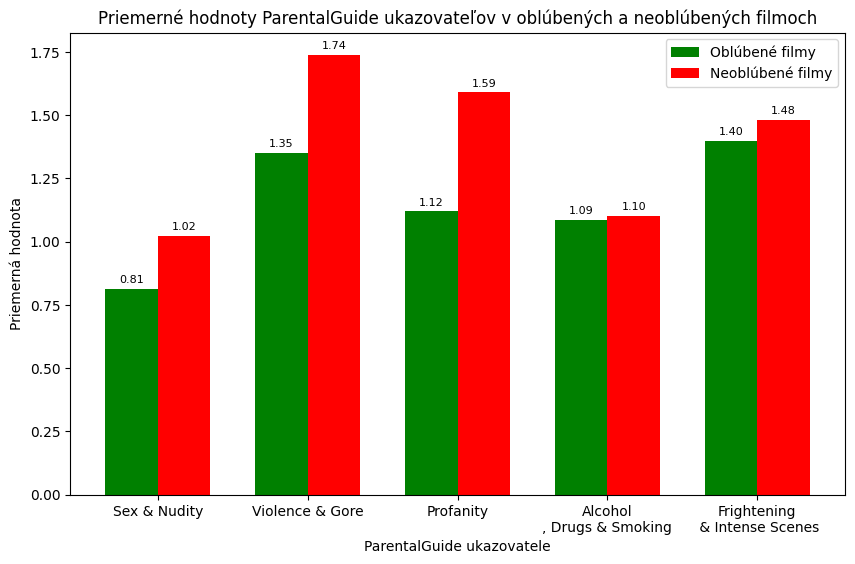

In [ ]:
import matplotlib.pyplot as plt

# Definícia hodnôt
labels = ['Sex & Nudity', 'Violence & Gore', 'Profanity', 'Alcohol\n, Drugs & Smoking', 'Frightening\n & Intense Scenes']
pop_means = [pop_parentGuide['nudity'].mean(), pop_parentGuide['violence'].mean(),
             pop_parentGuide['profanity'].mean(), pop_parentGuide['alcohol'].mean(),
             pop_parentGuide['frightening'].mean()]

nonpop_means = [nonpop_parentGuide['nudity'].mean(), nonpop_parentGuide['violence'].mean(),
                nonpop_parentGuide['profanity'].mean(), nonpop_parentGuide['alcohol'].mean(),
                nonpop_parentGuide['frightening'].mean()]

width = 0.35
x = range(len(labels))

fig, ax = plt.subplots(figsize=(10, 6))
v1 = ax.bar(x, pop_means, width, label='Oblúbené filmy', color='green')
v2 = ax.bar([i + width for i in x], nonpop_means, width, label='Neoblúbené filmy', color='red')

for v in v1:
    height = v.get_height()
    ax.annotate(f'{height:.2f}', xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

for v in v2:
    height = v.get_height()
    ax.annotate(f'{height:.2f}', xy=(v.get_x() + v.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

# Nastavenie osí
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.set_xlabel('ParentalGuide ukazovatele')
ax.set_ylabel('Priemerná hodnota')
ax.set_title('Priemerné hodnoty ParentalGuide ukazovateľov v oblúbených a neoblúbených filmoch')
ax.legend()

plt.show()

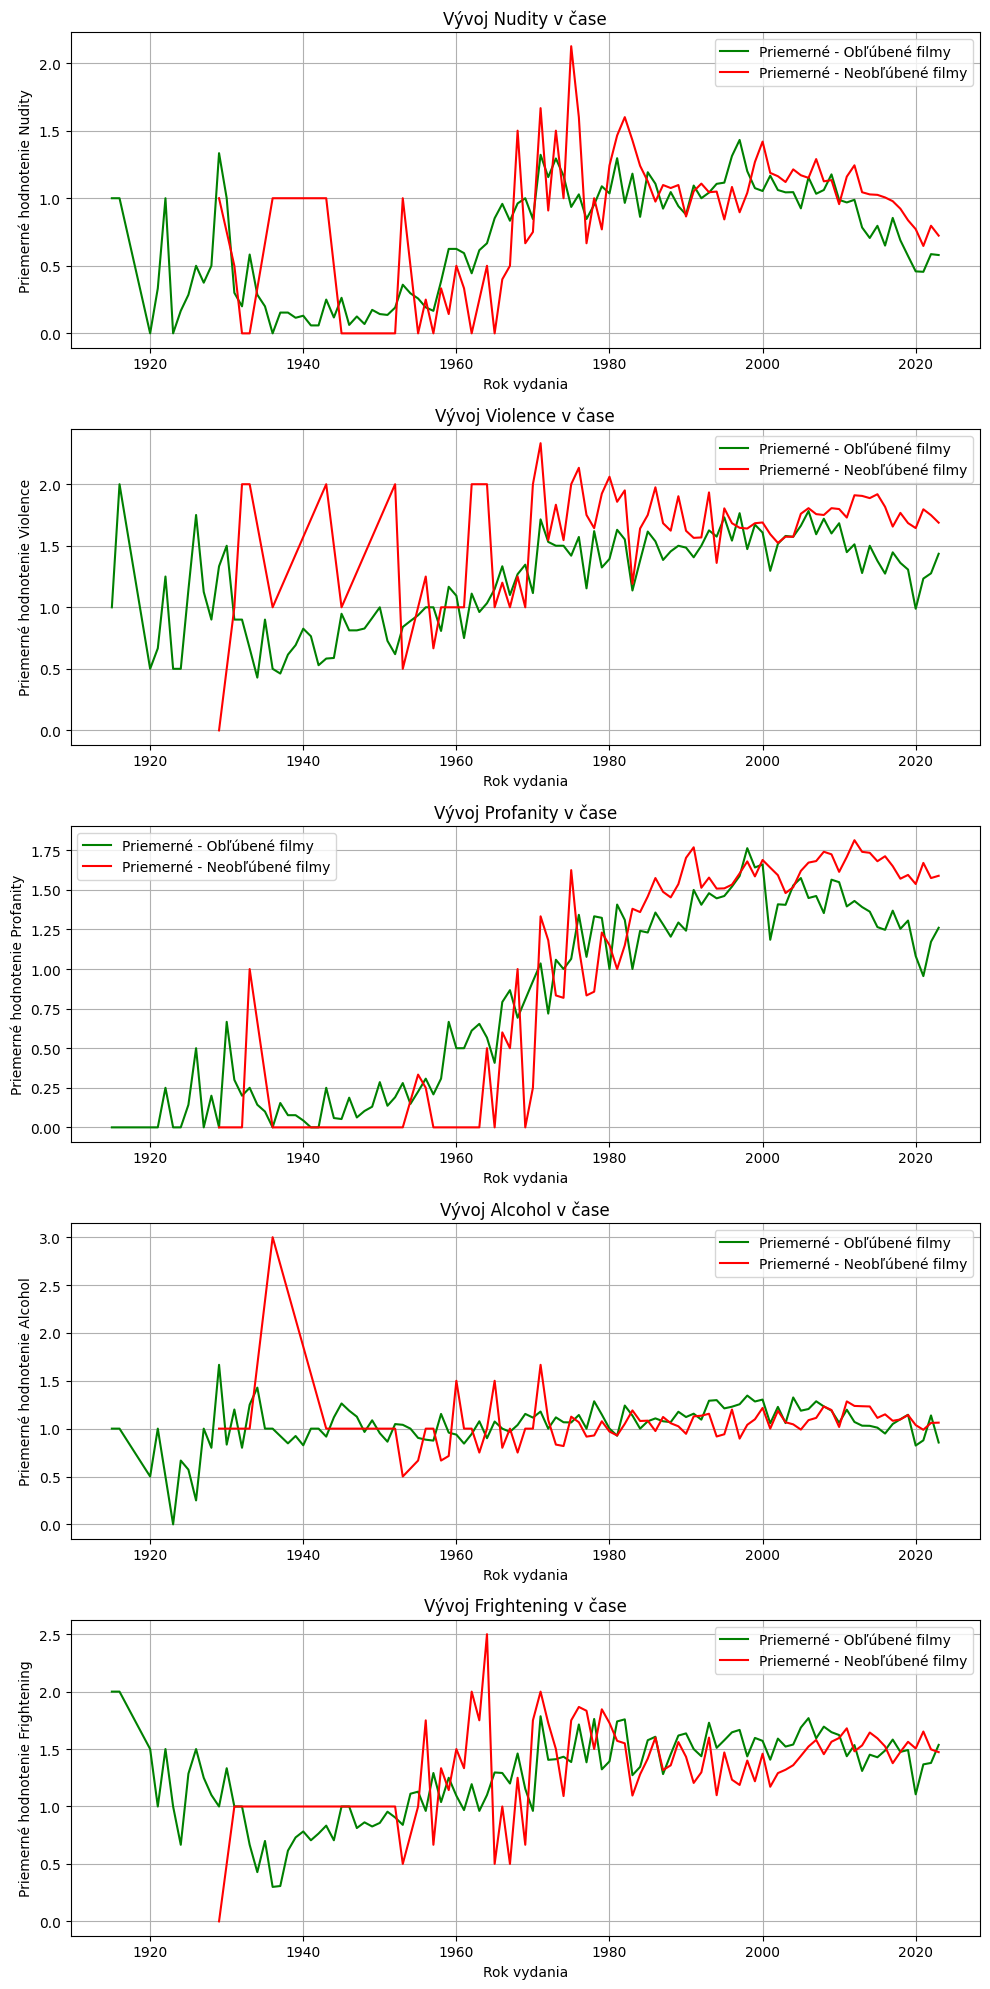

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

variables = ['nudity', 'violence', 'profanity', 'alcohol', 'frightening']

for i, variable in enumerate(variables):
    average_scores_by_year_pop = pop_parentGuide.groupby('releaseYear')[variable].mean()
    median_scores_by_year_pop = pop_parentGuide.groupby('releaseYear')[variable].median()

    average_scores_by_year_nonpop = nonpop_parentGuide.groupby('releaseYear')[variable].mean()
    median_scores_by_year_nonpop = nonpop_parentGuide.groupby('releaseYear')[variable].median()

    axes[i].plot(average_scores_by_year_pop.index, average_scores_by_year_pop.values, label='Priemerné - Obľúbené filmy', linestyle='-', color='green')
    # axes[i].plot(median_scores_by_year_pop.index, median_scores_by_year_pop.values, label='Medián - Obľúbené filmy', linestyle='--', color='lightgreen')

    axes[i].plot(average_scores_by_year_nonpop.index, average_scores_by_year_nonpop.values, label='Priemerné - Neobľúbené filmy', linestyle='-', color='red')
    # axes[i].plot(median_scores_by_year_nonpop.index, median_scores_by_year_nonpop.values, label='Medián - Neobľúbené filmy', linestyle='--', color='lightcoral')

    axes[i].set_xlabel('Rok vydania')
    axes[i].set_ylabel(f'Priemerné hodnotenie {variable.capitalize()}')
    axes[i].set_title(f'Vývoj {variable.capitalize()} v čase')

    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
rok_od = 1935
rok_do = 1940

# Počet filmov pre zadaný interval rokov
pocet_filmov_interval = len(nonpop_parentGuide[(nonpop_parentGuide['releaseYear'] >= rok_od) & (nonpop_parentGuide['releaseYear'] <= rok_do)])

print(f'Počet filmov pre roky {rok_od} - {rok_do}: {pocet_filmov_interval}')

Počet filmov pre roky 1935 - 1940: 1


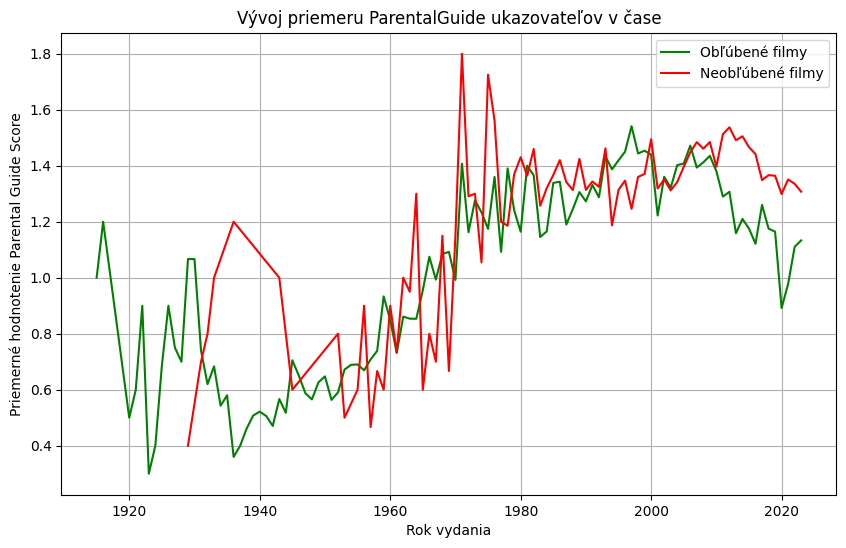

In [ ]:
plt.figure(figsize=(10, 6))

average_scores_by_year_pop = pop_parentGuide.groupby('releaseYear')['parentalGuideScore'].mean()
average_scores_by_year_nonpop = nonpop_parentGuide.groupby('releaseYear')['parentalGuideScore'].mean()

plt.plot(average_scores_by_year_pop.index, average_scores_by_year_pop.values, label='Obľúbené filmy', linestyle='-', color='green')

plt.plot(average_scores_by_year_nonpop.index, average_scores_by_year_nonpop.values, label='Neobľúbené filmy', linestyle='-', color='red')

plt.xlabel('Rok vydania')
plt.ylabel('Priemerné hodnotenie Parental Guide Score')
plt.title('Vývoj priemeru ParentalGuide ukazovateľov v čase')

plt.legend()

plt.grid(True)

plt.show()

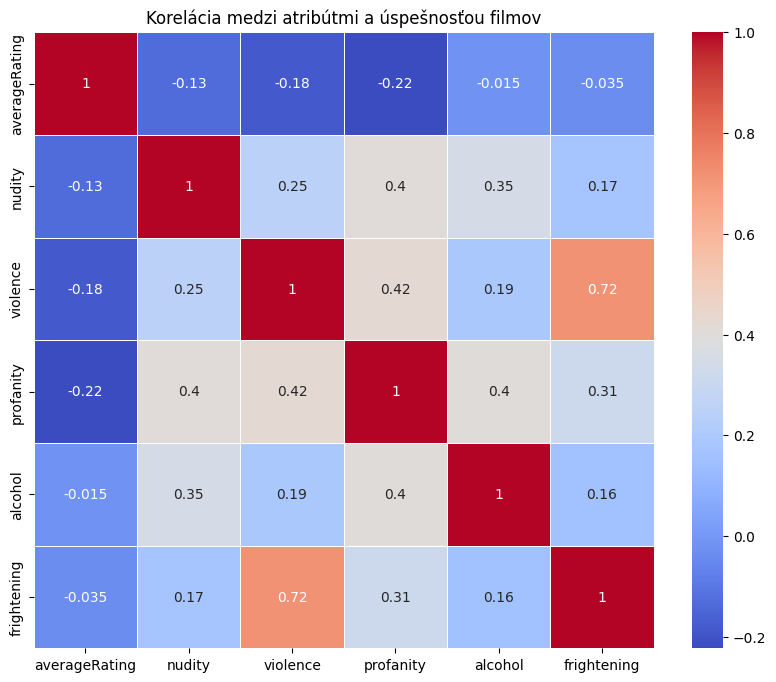

In [ ]:
merged_pop_nonpop = pd.concat([pop_parentGuide, nonpop_parentGuide], ignore_index=True)

correlation_columns = ['averageRating', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening']
correlation_data = merged_pop_nonpop[correlation_columns]
correlation_matrix = correlation_data.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, xticklabels=correlation_columns, yticklabels=correlation_columns)

plt.title('Korelácia medzi atribútmi a úspešnosťou filmov')

plt.show()

In [ ]:
def calculate_p_value(column, alternative='less'):
    group1 = merged_pop_nonpop[merged_pop_nonpop[column] > merged_pop_nonpop[column].mean()]['averageRating']
    group2 = merged_pop_nonpop[merged_pop_nonpop[column] <= merged_pop_nonpop[column].mean()]['averageRating']
    statistic, p_value = mannwhitneyu(group1, group2, alternative=alternative)
    print(f'Hodnota p_value pre {column}', p_value)

for column in ['parentalGuideScore', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening']:
    calculate_p_value(column)

Hodnota p_value pre parentalGuideScore 1.7050152126376218e-43
Hodnota p_value pre nudity 3.580844219627577e-33
Hodnota p_value pre violence 5.515945616988734e-48
Hodnota p_value pre profanity 8.172117093017337e-56
Hodnota p_value pre alcohol 0.013603687112616773
Hodnota p_value pre frightening 0.0008224208932753106


## **TOP herci popularnych filmov**

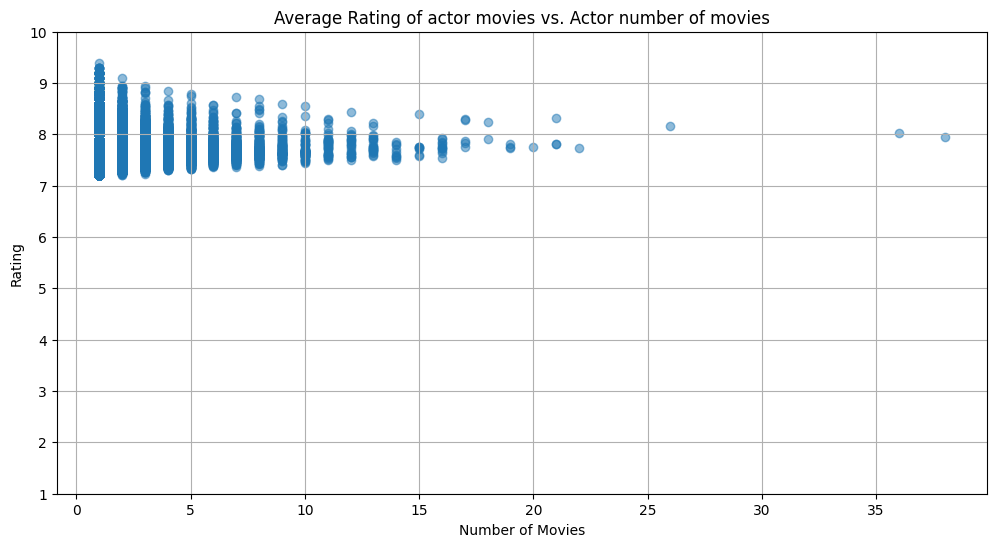

In [ ]:
actors_pop = pop_movies['actors'].str.split(',').explode()

pop_actors_movies = pd.concat([actors_pop, pop_movies['averageRating']], axis=1)
pop_actors_movies['film_count'] = pop_actors_movies.groupby('actors')['actors'].transform('count')

actor_stats = pop_actors_movies.groupby('actors').agg(
    avg_rating=('averageRating', 'mean'),
    std_rating=('averageRating', 'std'),
    film_count=('film_count', 'first')
).reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(actor_stats['film_count'], actor_stats['avg_rating'], alpha=0.5)
plt.title('Average Rating of actor movies vs. Actor number of movies')
plt.xlabel('Number of Movies')
plt.ylabel('Rating')
plt.grid(True)
plt.ylim(1,10)
plt.show()

confidence_level = 0.90  # 90% interval spoľahlivosti
z_score = norm.ppf((1 + confidence_level) / 2)

actor_stats['lower_bound'] = actor_stats['avg_rating'] - (confidence_level * actor_stats['std_rating'] / np.sqrt(actor_stats['film_count']))
actor_stats_sorted = actor_stats.sort_values(by='lower_bound', ascending=False).reset_index(drop=True)
top30actors_conf = actor_stats_sorted[:30]
actor_stats_sorted = actor_stats.sort_values(by='film_count', ascending=False).reset_index(drop=True)
top30actors_movcount = actor_stats_sorted[:30]

In [ ]:
top30actors_conf

actors  avg_rating  std_rating  film_count  lower_bound
0           Morgana King       9.100       0.141       2.000        9.010
1           Noel Appleby       8.950       0.071       2.000        8.905
2             Sean Astin       8.900       0.100       3.000        8.848
3          T.P. Madhavan       8.900       0.141       2.000        8.810
4     Fazlur Rahman Babu       8.900       0.141       2.000        8.810
5              John Bach       8.900       0.141       2.000        8.810
6        Md Mahedi Hasan       8.900       0.141       2.000        8.810
7             Sala Baker       8.850       0.071       2.000        8.805
8       Bülent Igdiroglu       8.933       0.252       3.000        8.803
9         Earl Carpenter       8.800       0.000       2.000        8.800
10         Hadley Fraser       8.800       0.000       2.000        8.800
11    Bobby Kottarakkara       8.833       0.153       3.000        8.754
12            Cem Gürdap       8.850       0.265       4.000        8.731
13           Ergin Orbey       8.780       0.130       5.000        8.728
14     Kaviyoor Ponnamma       8.833       0.208       3.000        8.725
15             Sam Mohan       8.950       0.354       2.000        8.725
16           David Aston       8.850       0.212       2.000        8.715
17          Frank Sivero       8.850       0.212       2.000        8.715
18         Milovan Tasic       8.750       0.071       2.000        8.705
19         Lizzie Antony       8.700       0.000       2.000        8.700
20   Supergood Subramani       8.700       0.000       2.000        8.700
21             Sankaradi       8.729       0.180       7.000        8.667
22   Oduvil Unnikrishnan       8.740       0.230       5.000        8.647
23        Hakki Karadayi       8.900       0.424       2.000        8.630
24             Fasi Khan       8.900       0.424       2.000        8.630
25          M.N. Nambiar       8.850       0.354       2.000        8.625
26              Parvathi       8.750       0.212       2.000        8.615
27         Hüseyin Kasif       8.800       0.361       3.000        8.613
28                Murali       8.700       0.173       3.000        8.610
29        Kôichi Hayashi       8.700       0.141       2.000        8.610

In [ ]:
top30actors_movcount

actors  avg_rating  std_rating  film_count  lower_bound
0           Prakash Raj       7.947       0.420      38.000        7.886
1                Nassar       8.036       0.434      36.000        7.971
2           Kemal Sunal       8.165       0.540      26.000        8.070
3     Samuel L. Jackson       7.727       0.412      22.000        7.648
4     Tanikella Bharani       7.819       0.429      21.000        7.735
5          Brahmanandam       7.805       0.417      21.000        7.723
6           Adile Nasit       8.324       0.527      21.000        8.220
7          Paresh Rawal       7.745       0.387      20.000        7.667
8             Tom Hanks       7.805       0.482      19.000        7.706
9          Willem Dafoe       7.742       0.345      19.000        7.671
10          Anupam Kher       7.758       0.293      19.000        7.697
11         Kamal Haasan       8.244       0.412      18.000        8.157
12        Michael Caine       7.917       0.552      18.000        7.800
13            Sener Sen       8.300       0.526      17.000        8.185
14       Saurabh Shukla       7.835       0.339      17.000        7.761
15        Robert Duvall       7.865       0.586      17.000        7.737
16          Aysen Gruda       8.271       0.535      17.000        8.154
17        James Stewart       7.747       0.458      17.000        7.647
18      Humphrey Bogart       7.731       0.314      16.000        7.661
19   Kota Srinivasa Rao       7.731       0.377      16.000        7.646
20     Chet Brandenburg       7.544       0.219      16.000        7.494
21                 Ajay       7.669       0.320      16.000        7.597
22       Robert De Niro       7.844       0.398      16.000        7.754
23   Scarlett Johansson       7.794       0.406      16.000        7.702
24        Rajesh Sharma       7.763       0.326      16.000        7.689
25     Amitabh Bachchan       7.825       0.336      16.000        7.749
26       Toshirô Mifune       7.931       0.425      16.000        7.836
27         J.K. Simmons       7.631       0.368      16.000        7.548
28         Murli Sharma       7.725       0.375      16.000        7.641
29    Leonardo DiCaprio       7.906       0.427      16.000        7.810

In [ ]:
actors_pop = pop_movies['actors'].str.split(',', expand=True).stack().reset_index(level=0, drop=True).reset_index(name='actor')
actors_nonpop = nonpop_movies['actors'].str.split(',', expand=True).stack().reset_index(level=0, drop=True).reset_index(name='actor')
actor_counts_pop = actors_pop['actor'].value_counts().reset_index()
actor_counts_pop.columns = ['actor', 'pop_count']

actor_counts_nonpop = actors_nonpop['actor'].value_counts().reset_index()
actor_counts_nonpop.columns = ['actor', 'nonpop_count']
merged_actor_counts = pd.merge(actor_counts_pop, actor_counts_nonpop, on='actor', how='outer').fillna(0)
merged_actor_counts['count_difference'] = merged_actor_counts['pop_count'] - merged_actor_counts['nonpop_count']
merged_actor_counts_sorted = merged_actor_counts.sort_values(by=['count_difference','pop_count'], ascending=False).reset_index(drop=True)

In [ ]:
print(merged_actor_counts_sorted.head(30))

                    actor  pop_count  nonpop_count  count_difference
0             Prakash Raj     38.000         8.000            30.000
1                  Nassar     36.000         7.000            29.000
2             Kemal Sunal     26.000         0.000            26.000
3             Adile Nasit     21.000         0.000            21.000
4            Kamal Haasan     18.000         0.000            18.000
5               Sener Sen     17.000         0.000            17.000
6           James Stewart     17.000         0.000            17.000
7               Tom Hanks     19.000         3.000            16.000
8       Leonardo DiCaprio     16.000         0.000            16.000
9         Humphrey Bogart     16.000         0.000            16.000
10         Toshirô Mifune     16.000         0.000            16.000
11      Tanikella Bharani     21.000         6.000            15.000
12           Brahmanandam     21.000         6.000            15.000
13       Chet Brandenburg     16.0

## **Produkčné firmy a priemerné hodnotenie filmov**

NaN pop:  77
NaN nonpop:  78


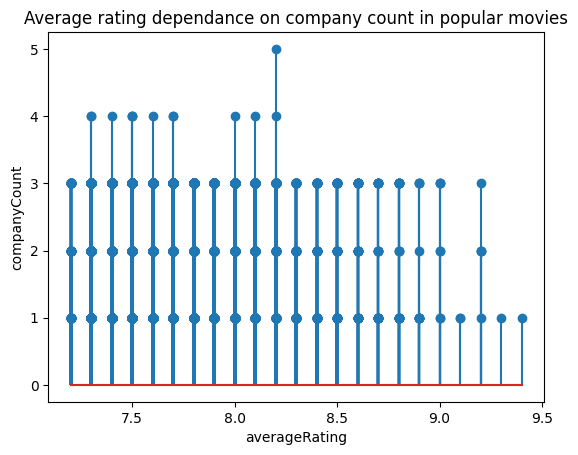

<ipython-input-119-7fb8f60ce642>:20: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



               averageRating  companyCount
averageRating          1.000        -0.114
companyCount          -0.114         1.000


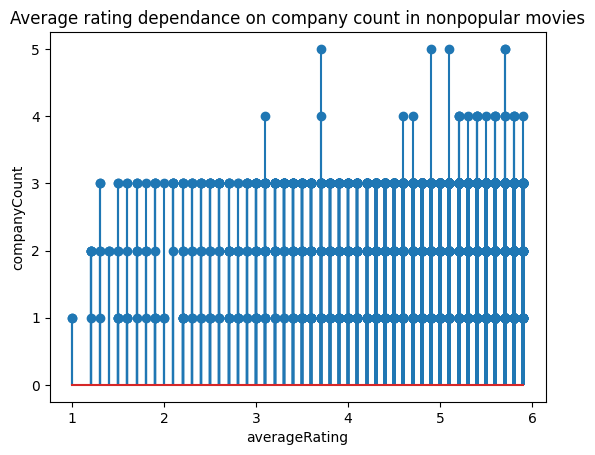

               averageRating  companyCount
averageRating          1.000         0.104
companyCount           0.104         1.000


<ipython-input-119-7fb8f60ce642>:28: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [ ]:
pop_filtered = pop_movies[['tconst', 'primaryTitle', 'averageRating', 'productionCompanies']].copy()
nonpop_filtered = nonpop_movies[['tconst', 'primaryTitle', 'averageRating', 'productionCompanies']].copy()
print("NaN pop: ", pop_filtered['productionCompanies'].isna().sum())
print("NaN nonpop: ", nonpop_filtered['productionCompanies'].isna().sum())
pop_filtered.dropna(inplace=True)
nonpop_filtered.dropna(inplace=True)

count_items = lambda x: len(x.split(','))
pop_filtered['companyCount'] = pop_filtered['productionCompanies'].apply(count_items)
nonpop_filtered['companyCount'] = nonpop_filtered['productionCompanies'].apply(count_items)

# display(pop_filtered.head())

plt.stem(pop_filtered['averageRating'], pop_filtered['companyCount'])
plt.title("Average rating dependance on company count in popular movies")
plt.ylabel("companyCount")
plt.xlabel("averageRating")
plt.show()

print(pop_filtered.corr())

plt.stem(nonpop_filtered['averageRating'], nonpop_filtered['companyCount'])
plt.title("Average rating dependance on company count in nonpopular movies")
plt.ylabel("companyCount")
plt.xlabel("averageRating")
plt.show()

print(nonpop_filtered.corr())

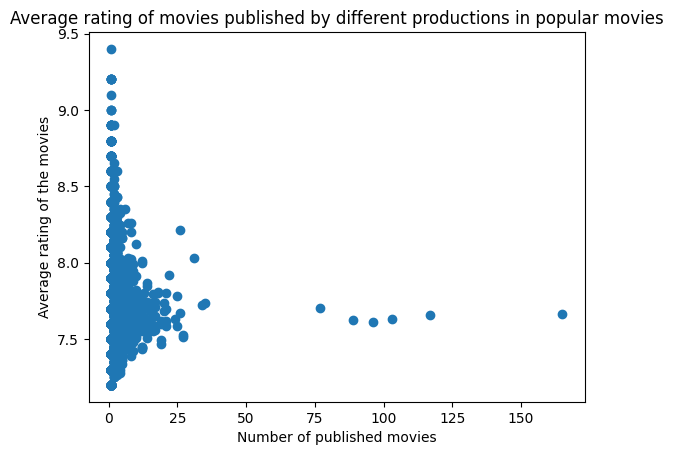

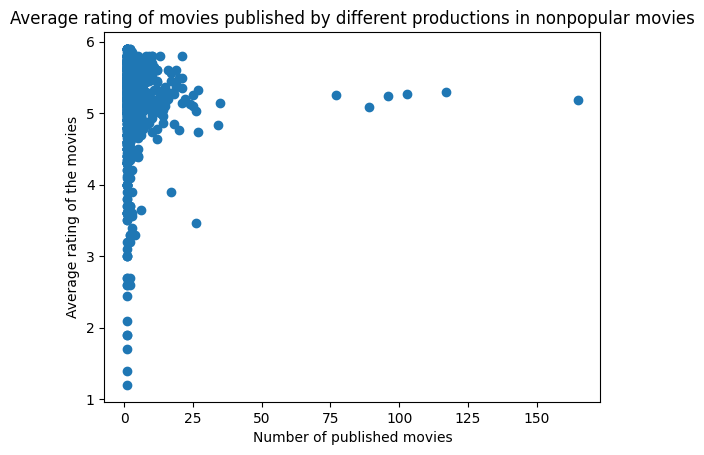

In [ ]:
# popular movies
count_dict = dict()
for index, row in pop_filtered.iterrows():
    items = row['productionCompanies'].split(',')
    for item in items:
      count_dict[item] = count_dict.get(item, 0) + 1
reshaped_data = [{'company': key, 'counter': value} for key, value in count_dict.items()]
df_01 = pd.DataFrame(reshaped_data)


company_rating = pd.DataFrame(columns=['company', 'total_rating', 'count'])

for i, row in pop_filtered.iterrows():
    companies = row['productionCompanies'].split(',')
    rating = row['averageRating']

    data_to_append = []

    for company in companies:
        if company not in company_rating['company'].values:
            data_to_append.append({'company': company, 'total_rating': rating, 'count': 1})
        else:
            company_rating.loc[company_rating['company'] == company, 'total_rating'] += rating
            company_rating.loc[company_rating['company'] == company, 'count'] += 1

    if data_to_append:
        company_rating = pd.concat([company_rating, pd.DataFrame(data_to_append)], ignore_index=True)

df_001 = pd.merge(company_rating, df_01, on='company', how='left')
df_001['AVG'] = df_001['total_rating']/df_001['count']
plt.scatter(df_001['counter'], df_001['AVG'])
plt.title('Average rating of movies published by different productions in popular movies')
plt.xlabel('Number of published movies')
plt.ylabel('Average rating of the movies')
plt.show()

# nonpopular movies
count_dict = dict()
for index, row in pop_filtered.iterrows():
    items = row['productionCompanies'].split(',')
    for item in items:
      count_dict[item] = count_dict.get(item, 0) + 1
reshaped_data = [{'company': key, 'counter': value} for key, value in count_dict.items()]
df_01 = pd.DataFrame(reshaped_data)


company_rating = pd.DataFrame(columns=['company', 'total_rating', 'count'])

for i, row in nonpop_filtered.iterrows():
    companies = row['productionCompanies'].split(',')
    rating = row['averageRating']

    data_to_append = []

    for company in companies:
        if company not in company_rating['company'].values:
            data_to_append.append({'company': company, 'total_rating': rating, 'count': 1})
        else:
            company_rating.loc[company_rating['company'] == company, 'total_rating'] += rating
            company_rating.loc[company_rating['company'] == company, 'count'] += 1

    if data_to_append:
        company_rating = pd.concat([company_rating, pd.DataFrame(data_to_append)], ignore_index=True)

df_001 = pd.merge(company_rating, df_01, on='company', how='left')
df_001['AVG'] = df_001['total_rating']/df_001['count']
plt.scatter(df_001['counter'], df_001['AVG'])
plt.title('Average rating of movies published by different productions in nonpopular movies')
plt.xlabel('Number of published movies')
plt.ylabel('Average rating of the movies')
plt.show()

## **Krajiny pôvodu**

In [ ]:
print(f"Short description in popular movies of {'countriesOfOrigin'}:\n{pop_movies['countriesOfOrigin'].describe().to_string()}\n")
# print(f"Short description in not popular of {'countriesOfOrigin'}:\n{nonpop_movies['countriesOfOrigin'].describe().to_string()}\n")


def calculate_country_weight(countries):
    countries_list = countries.split(', ')
    num_countries = len(countries_list)
    if num_countries > 1:
        return 1 / num_countries
    else:
        return 1

def rating_vs_country(data):
    data = data.drop(data[data['countriesOfOrigin'].apply(type) == float].index)
    data['country_weight'] = data['countriesOfOrigin'].apply(calculate_country_weight)

    transformed_country = []
    transformed_ratings = []
    transformed_weights = []

    for country, rating, weight in zip(data['countriesOfOrigin'], data['averageRating'], data['country_weight']):
        countries = country.split(', ')
        for country in countries:
            transformed_country.append(country)
            transformed_ratings.append(rating)
            transformed_weights.append(weight)

    new_data = {
        'country': transformed_country,
        'rating': transformed_ratings,
        'weight' : transformed_weights
    }

    new_df = pd.DataFrame(new_data)

    country_summary = new_df.groupby('country').agg({'rating': 'mean', 'weight': 'sum'}).reset_index()

    fig = px.scatter(country_summary, x='rating', y='country', size='weight',
                    hover_name='country', color='country',
                    labels={'rating': 'Priemerné hodnotenie', 'country': 'Krajina', 'weight': 'Počet filmov'},
                    size_max=60)

    fig.update_layout(title='Priemerné hodnotenie podľa krajiny s ohľadom na sumu váh',
                      xaxis_title='Priemerné hodnotenie',
                      yaxis=dict(showticklabels=False),
                      yaxis_title='')

    fig.show()

    return new_df

pop = rating_vs_country(pop_movies)
unpop = rating_vs_country(nonpop_movies)

Short description in popular movies of countriesOfOrigin:
count              4840
unique              766
top       United States
freq               1482

